# IAU - Predspracovanie (Marcel Veselý 65%, Maroš Hnat 35%)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import json
import scipy.stats as stats
import math



import statsmodels.api as sm
import statsmodels.stats as sm_stats
import statsmodels.stats.api as sms

import vizualizacia_funkcie as visual


from sklearn.experimental import enable_iterative_imputer 
from sklearn import impute 
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import base
from sklearn import compose
from datetime import datetime
from datetime import date
from sklearn.impute import KNNImputer

#toto najma pouzivame pri seaborne, kedy pouzivame funkciu sns.distplot, ktora je zastarala
import warnings
warnings.filterwarnings('ignore')

In [2]:
import category_encoders as ce

In [3]:
df1 = pd.read_csv("./data/personal_train.csv", index_col=0)
df2 = pd.read_csv("./data/other_train.csv", index_col=0)

In [4]:
#moje su len vo vacsom dataframe
attributes_marcel = ["marital-status", "relationship", "occupation", "income", "workclass", 
                     "hours-per-week", "medical_info", "class"]

# Joinutie dataframov

In [5]:
print("Rozmer df1", df1.shape)
print("Rozmer df2", df2.shape)

print(len(df1["name"].unique()))
print(len(df1["address"].unique()))

print(len(df2["name"].unique()))
print(len(df2["address"].unique()))

Rozmer df1 (3933, 5)
Rozmer df2 (3983, 22)
3933
3933
3933
3933


Vidime, ze je rovnaky pocet unique values pre meno a adresu v obidvoch dataframoch. My totiz hladame najlepsi kluc, podla ktoreho by sme vedeli joinut obe dataframy dokopy. Sice maju rozdielne rozmery, ale minule, pri analyze, sme zistili, ze niektori pacienti maju pridelene 2 datarowy, kedy obe zaznamy su nie plne vyplnene - v zmysle, ze je mozne nasledne mergnut dane 2 zaznamy do jedneho, cim ziskavame jeden zaznam zo vsetkymi informaciami, ktore boli dostupne v tych dvoch zaznamoch.

In [6]:
key1 = sorted(list(df1["name"].unique() + " " + df1["address"].unique()))
key2 = sorted(list(df2["name"].unique() + " " + df2["address"].unique()))

key1[:10]

['Aaron Davis 379 Rodriguez Inlet\r\nFisherbury, MD 83114',
 'Aaron Dini 105 Medina Springs Suite 462\r\nEmilyland, KS 59124',
 'Aaron Gann 59685 Thomas Extension Apt. 142\r\nFieldsborough, UT 17996',
 'Aaron Gregg 10883 Williams Locks Suite 821\r\nEast Carmen, ME 31095',
 'Aaron Lindley 564 Stevenson Park Apt. 839\r\nRodriguezville, AR 73176',
 'Aaron Manning 9503 Christy Meadow\r\nAntoniostad, DC 31369',
 'Aaron Moody 5443 Kurt Estate\r\nHillbury, MS 07587',
 'Aaron Noman PSC 0351, Box 8841\r\nAPO AA 86063',
 'Aaron Robinson 16767 Medina Manor Suite 889\r\nCarlosshire, MD 96418',
 'Aaron Rogers 3257 Jones Center Apt. 917\r\nSeanland, OH 20838']

In [7]:
key1 == key2

True

Vidime, ze oba dataframy zdielaju rovnake informacie o pacientovi, konkretne o jeho mene a adrese. Tak mozeme tieto dva dataframy joinut na zaklade mena, pricom vymazeme prvotne adresu z jedneho dataframu

In [8]:
data = df1.drop(columns=["address"]).set_index("name").join(df2.set_index("name"), how="right").reset_index()
data

name   age      sex        date_of_birth  \
0            Aaron Davis    56   Female           1962-12-27   
1             Aaron Dini    50     Male           1969-05-22   
2             Aaron Gann    25     Male           1994-07-26   
3            Aaron Gregg    42   Female           1977-04-16   
4          Aaron Lindley -4900   Female  1969-12-11 00:00:00   
...                  ...   ...      ...                  ...   
3978      Young Provines    51     Male           1968-05-19   
3979  Zachary Grandfield -5800     Male           1960/12/18   
3980      Zachary Miller    46     Male           1973-08-07   
3981     Zachary Seltzer    64   Female  1955-06-08 00 00 00   
3982       Zane Bottorff    44     Male  1975-08-24 00 00 00   

                                                address    race  \
0           379 Rodriguez Inlet\r\nFisherbury, MD 83114   White   
1     105 Medina Springs Suite 462\r\nEmilyland, KS ...   White   
2     59685 Thomas Extension Apt. 142\r\nFieldsborou...   Black   
3     10883 Williams Locks Suite 821\r\nEast Carmen,...   Black   
4     564 Stevenson Park Apt. 839\r\nRodriguezville,...   White   
...                                                 ...     ...   
3978  7993 Sharon Roads Suite 311\r\nPort Daniel, GA...   White   
3979  77606 Maxwell Rest Apt. 485\r\nPort Jennifer, ...   Black   
3980      96654 Marc Stream\r\nEast Cassandra, VT 84597   White   
3981  38371 Crystal Stravenue\r\nPerkinsmouth, DE 20764   White   
3982   71075 Taylor Summit\r\nSouth Kevinside, MD 24906   White   

           marital-status         occupation pregnant  education-num  ...  \
0                Divorced      Other-service        f            3.0  ...   
1                Divorced              Sales        f           10.0  ...   
2           Never-married                  ?        f            4.0  ...   
3                 Widowed   Transport-moving        f            9.0  ...   
4           Never-married              Sales        F            9.0  ...   
...                   ...                ...      ...            ...  ...   
3978   Married-civ-spouse    Exec_managerial    FALSE           11.0  ...   
3979   Married-civ-spouse   Transport-moving        f           10.0  ...   
3980   Married-civ-spouse       Adm-clerical        f           13.0  ...   
3981             Divorced              Sales        f            7.0  ...   
3982        Never-married   Transport-moving    FALSE            9.0  ...   

          education    fnlwgt class  std_glucose  income  \
0           5th-6th  199298.0   0.0    41.806596   <=50K   
1      Some-college  120939.0   0.0    53.615229   <=50K   
2           7th-8th  107112.0   0.0    50.476073   <=50K   
3           HS-grad  157942.0   0.0    35.976649   <=50K   
4           HS-grad  156084.0   0.0    54.280153   <=50K   
...             ...       ...   ...          ...     ...   
3978      Assoc-voc   83444.0   1.0    44.303479    >50K   
3979   Some-college  343849.0   1.0    29.456767   <=50K   
3980      Bachelors  162327.0   0.0    43.191434    >50K   
3981           11th  444089.0   1.0    34.132553   <=50K   
3982        HS-grad  226196.0   1.0    51.931368   <=50K   

                                           medical_info  native-country  \
0     {'mean_oxygen':'1.647157191','std_oxygen':'14....               ?   
1     {'mean_oxygen':'1.380434783','std_oxygen':'15....   United-States   
2     {'mean_oxygen':'78.30183946','std_oxygen':'79....   United-States   
3     {'mean_oxygen':'1.489130435','std_oxygen':'10....   United-States   
4     {'mean_oxygen':'1.194816054','std_oxygen':'11....   United-States   
...                                                 ...             ...   
3978  {'mean_oxygen':'3.16722408','std_oxygen':'22.3...   United-States   
3979  {'mean_oxygen':'2.994147157','std_oxygen':'21....   United-States   
3980  {'mean_oxygen':'1.62541806','std_oxygen':'14.0...               ?   
3981  {'mean_oxygen':'66.53260870000001','std_oxyg

# Merguntie viacerych zaznamov jedneho pacienta

Podme sa teraz pozriet na problem mergovania dat dvoch zaznamov jedneho pacienta do jedneho datarowu. Ako priklad sme si zobrali cloveka, ktory ma 2 zaznamy v nasom datasete, pricom ako mozno vidiet, existuje zopar atributov, ktore su u jedneho zaznamu nullove, zatial co u druheho nie su. Prikladom je napriklad relationship.

In [9]:
daniel = data.loc[data["name"] == "Daniel Martin"]
print(daniel.iloc[0].isnull() ^ daniel.iloc[1].isnull())

daniel["relationship"]

name                False
age                 False
sex                 False
date_of_birth       False
address             False
race                False
marital-status      False
occupation          False
pregnant            False
education-num       False
relationship         True
skewness_glucose    False
mean_glucose         True
capital-gain        False
kurtosis_glucose    False
education           False
fnlwgt               True
class               False
std_glucose         False
income              False
medical_info         True
native-country      False
hours-per-week       True
capital-loss        False
workclass            True
dtype: bool


678     Husband
679         NaN
Name: relationship, dtype: object

Taktiez, niekto by mohol argumentovat, ze su to 2 rozlicne medicinske zaznamy rovnakeho pacienta, a nejde o jedno meranie, no toto sme uz minule vyvratili, staci sa pozriet na namerane hodnoty cloveku

In [10]:
daniel2 = daniel.dropna(axis=1)

daniel2.iloc[0] == daniel2.iloc[1]

name                True
age                 True
sex                 True
date_of_birth       True
address             True
race                True
marital-status      True
occupation          True
pregnant            True
education-num       True
skewness_glucose    True
capital-gain        True
kurtosis_glucose    True
education           True
class               True
std_glucose         True
income              True
native-country      True
capital-loss        True
dtype: bool

In [11]:
daniel2

name  age    sex date_of_birth  \
678  Daniel Martin   55   Male    1964-02-02   
679  Daniel Martin   55   Male    1964-02-02   

                                               address    race  \
678  1600 Shaun Drive Apt. 113\r\nEast Jacobmouth, ...   White   
679  1600 Shaun Drive Apt. 113\r\nEast Jacobmouth, ...   White   

          marital-status       occupation pregnant  education-num  \
678   Married-civ-spouse   Prof-specialty        f           14.0   
679   Married-civ-spouse   Prof-specialty        f           14.0   

     skewness_glucose  capital-gain  kurtosis_glucose education  class  \
678         -0.575827           0.0         -0.065923   Masters    0.0   
679         -0.575827           0.0         -0.065923   Masters    0.0   

     std_glucose income  native-country  capital-loss  
678    55.072854   >50K   United-States        1887.0  
679    55.072854   >50K   United-States        1887.0

Ako mozno vidiet, ide o rovnake medicinske zaznamy, staci sa pozriet na merania glukozy, ktore su "nachlp" presne

In [12]:
#funckia, ktora mergne zaznamy, ktore su rovnake
def piece_datarows_together(data):
    
    data = data.copy().set_index("name")
    
    #toto nam vrati dataset, ktory obsahuje vsetky duplikaty, s ktorymi budeme pracovat
    #proste to vrati data, ktore maju index, ktory je v datasete viac ako raz pouzity
    duplicated = data[data.index.duplicated(keep=False)]
    
    index_values = duplicated.index.unique()
    
    #najprv vsetky hodnoty prenesieme do prveho vyskytu zaznamu daneho pacienta v datasete
    for idx in index_values:
        mini_dataset = duplicated.loc[idx] #toto vrati viacero zaznamov s rovnakych idx
        
        #zistim si, ktore atributy su nullove pre presne prvy zaznam a pre konkretne nullove atributy budem nadalej hladat
        #nenullovu hodnotu v ostatnych zaznamoch s rovnakym idx
        missing_mask = mini_dataset.iloc[0].isnull()
        attributes = mini_dataset.columns.values
        missing_attributes = attributes[missing_mask]
        
        #tu replacujem null hodnoty za nenullove
        for attr in missing_attributes:
            not_null = mini_dataset[attr][mini_dataset[attr].notnull()]
            
            if len(not_null) != 0:
                mini_dataset.iloc[0][attr] = not_null.values[0]
        
        
    #teraz uz mozme vymazat vsetky druhe, resp. ostatne zaznamy pacienta
    duplicated_mask = data.index.duplicated(keep="first")
    
    data = data.reset_index()
    duplicated_indices = data.index.values[duplicated_mask]
    
    
    return data.drop(index=duplicated_indices).reset_index(drop=True)


In [13]:
data = piece_datarows_together(data)

In [14]:
data

name   age      sex        date_of_birth  \
0            Aaron Davis    56   Female           1962-12-27   
1             Aaron Dini    50     Male           1969-05-22   
2             Aaron Gann    25     Male           1994-07-26   
3            Aaron Gregg    42   Female           1977-04-16   
4          Aaron Lindley -4900   Female  1969-12-11 00:00:00   
...                  ...   ...      ...                  ...   
3928      Young Provines    51     Male           1968-05-19   
3929  Zachary Grandfield -5800     Male           1960/12/18   
3930      Zachary Miller    46     Male           1973-08-07   
3931     Zachary Seltzer    64   Female  1955-06-08 00 00 00   
3932       Zane Bottorff    44     Male  1975-08-24 00 00 00   

                                                address    race  \
0           379 Rodriguez Inlet\r\nFisherbury, MD 83114   White   
1     105 Medina Springs Suite 462\r\nEmilyland, KS ...   White   
2     59685 Thomas Extension Apt. 142\r\nFieldsborou...   Black   
3     10883 Williams Locks Suite 821\r\nEast Carmen,...   Black   
4     564 Stevenson Park Apt. 839\r\nRodriguezville,...   White   
...                                                 ...     ...   
3928  7993 Sharon Roads Suite 311\r\nPort Daniel, GA...   White   
3929  77606 Maxwell Rest Apt. 485\r\nPort Jennifer, ...   Black   
3930      96654 Marc Stream\r\nEast Cassandra, VT 84597   White   
3931  38371 Crystal Stravenue\r\nPerkinsmouth, DE 20764   White   
3932   71075 Taylor Summit\r\nSouth Kevinside, MD 24906   White   

           marital-status         occupation pregnant  education-num  ...  \
0                Divorced      Other-service        f            3.0  ...   
1                Divorced              Sales        f           10.0  ...   
2           Never-married                  ?        f            4.0  ...   
3                 Widowed   Transport-moving        f            9.0  ...   
4           Never-married              Sales        F            9.0  ...   
...                   ...                ...      ...            ...  ...   
3928   Married-civ-spouse    Exec_managerial    FALSE           11.0  ...   
3929   Married-civ-spouse   Transport-moving        f           10.0  ...   
3930   Married-civ-spouse       Adm-clerical        f           13.0  ...   
3931             Divorced              Sales        f            7.0  ...   
3932        Never-married   Transport-moving    FALSE            9.0  ...   

          education    fnlwgt class  std_glucose  income  \
0           5th-6th  199298.0   0.0    41.806596   <=50K   
1      Some-college  120939.0   0.0    53.615229   <=50K   
2           7th-8th  107112.0   0.0    50.476073   <=50K   
3           HS-grad  157942.0   0.0    35.976649   <=50K   
4           HS-grad  156084.0   0.0    54.280153   <=50K   
...             ...       ...   ...          ...     ...   
3928      Assoc-voc   83444.0   1.0    44.303479    >50K   
3929   Some-college  343849.0   1.0    29.456767   <=50K   
3930      Bachelors  162327.0   0.0    43.191434    >50K   
3931           11th  444089.0   1.0    34.132553   <=50K   
3932        HS-grad  226196.0   1.0    51.931368   <=50K   

                                           medical_info  native-country  \
0     {'mean_oxygen':'1.647157191','std_oxygen':'14....               ?   
1     {'mean_oxygen':'1.380434783','std_oxygen':'15....   United-States   
2     {'mean_oxygen':'78.30183946','std_oxygen':'79....   United-States   
3     {'mean_oxygen':'1.489130435','std_oxygen':'10....   United-States   
4     {'mean_oxygen':'1.194816054','std_oxygen':'11....   United-States   
...                                                 ...             ...   
3928  {'mean_oxygen':'3.16722408','std_oxygen':'22.3...   United-States   
3929  {'mean_oxygen':'2.994147157','std_oxygen':'21....   United-States   
3930  {'mean_oxygen':'1.62541806','std_oxygen':'14.0...               ?   
3931  {'mean_oxygen':'66.53260870000001','std_oxyg

In [15]:
print(data["name"].value_counts())
data.loc[data["name"] == "Daniel Martin"]

Luciano Armstrong     1
Frank Prather         1
Robert Wynia          1
John Swoopes          1
James Kowalski        1
                     ..
Richard Williams      1
Jesus Craner          1
Fernando Rowan        1
Christopher Wilson    1
Antonio Bailey        1
Name: name, Length: 3933, dtype: int64


name  age    sex date_of_birth  \
675  Daniel Martin   55   Male    1964-02-02   

                                               address    race  \
675  1600 Shaun Drive Apt. 113\r\nEast Jacobmouth, ...   White   

          marital-status       occupation pregnant  education-num  ...  \
675   Married-civ-spouse   Prof-specialty        f           14.0  ...   

    education    fnlwgt class  std_glucose  income  \
675   Masters  146659.0   0.0    55.072854    >50K   

                                          medical_info  native-country  \
675  {'mean_oxygen':'2.369565217','std_oxygen':'14....   United-States   

     hours-per-week  capital-loss workclass  
675             NaN        1887.0       NaN  

[1 rows x 25 columns]

# Odstranenie useless atributov

Teraz, co sme uz joinli obidva dataframy a mergli datarowy, ktore boli z nejakeho dovodu rozdelene, sa mozeme pozriet na samotne atributy a spracovat ich.

V prvom rade vsak vyhodime atributy, ktore su uplne useless. Medzi nimi patri: 
- capital-gain 
- capital-loss

Dovodom, preco tieto mazeme, je ze 90% vsetkych ich hodnot su same 0.

Potom medzi dalsimi kandidatmi, ktore mozme hned vymazat budu:
- name
- date_of_birth - zatial ho nebudeme mazat, pouzijeme na imputaciu agu
- address - z tadialto chceme este precitat napriklad stat, v ktorom sa to robilo (najma sa teraz bavime o USA a ich statoch)
- fnlwgt - kedze nenasiel som ziadnu korelaciu medzi tymto vztahom a inymi ciselnymi hodnotami, ako aj nema korelaciu so samotnym prediction - class
- pregnant - je velmi malo tehotnych ludi necele 2%

In [16]:
data = data.drop(columns=["capital-gain", "capital-loss", "name", "fnlwgt", "pregnant"])

data.columns

Index(['age', 'sex', 'date_of_birth', 'address', 'race', 'marital-status',
       'occupation', 'education-num', 'relationship', 'skewness_glucose',
       'mean_glucose', 'kurtosis_glucose', 'education', 'class', 'std_glucose',
       'income', 'medical_info', 'native-country', 'hours-per-week',
       'workclass'],
      dtype='object')

Este stale mame dost atributov, ktore nemusia mat so predikciou cukrovky ziadnu suvislost. Ale vacsina tychto atributov sa najlepsie urci, ci su potrebne alebo nie, na zaklade samotneho trenovania modelu s a bez danych parametrov. 

Este, v priebehu tohto 2. zadania, sa pokusime najst nejake atributy, ktore nemaju vypovednu hodnotu, napriklad pomocou VarianceThreshold, ale teraz v datasete mame velke mnozstvo kategorickych hodnot, ako aj mnozstvo zle zformatovanych udajov, a tak skontrolovanie variancie jednotlivych atributov vykoname neskorsie, ked ich trosku spracujeme... Teraz sa budeme venovat jednotlivym atributom a ich spravovaniu. 

Nakoniec, ked budeme mat vykonane vsetky upravy nad atributmi, tak to vsetko spojime dokopy pouzivajuc triedy v scikit kniznici, ako napriklad Pipeline, ColumnTransform a pod.

# Preprocessing jednotlivych atributov

In [17]:
def identify_outliers(a):
    q25 = a.quantile(0.25)
    q75 = a.quantile(0.75)
    
    iqr = q75-q25
        
    lower = q25 - 1.5 * iqr
    upper = q75 + 1.5 * iqr
    
    return a[(a > upper) | (a < lower)]

Zbavime sa whitespacov vo vacsine stringovych atributoch...

In [18]:
data.columns

Index(['age', 'sex', 'date_of_birth', 'address', 'race', 'marital-status',
       'occupation', 'education-num', 'relationship', 'skewness_glucose',
       'mean_glucose', 'kurtosis_glucose', 'education', 'class', 'std_glucose',
       'income', 'medical_info', 'native-country', 'hours-per-week',
       'workclass'],
      dtype='object')

In [19]:
def string_formatting(col):
    
    if col.dtype == "O":
        col = col.apply(lambda row: row.strip() if row is not np.nan else row)
        col = col.apply(lambda row: np.nan if row is not np.nan and row == "?" else row)
    
    return col

data = data.apply(string_formatting)

### class

Tomuto atributu chyba zopar hodnot, konkretne 9, a tak datam by sme neublizili, pokial by sme ich jednoducho dropli. Kludne by sme mohli aj imputovat dane hodnoty, mame dobre atributy so silnymi korelaciami s tymto atributom, a tak by sme sa hrali, ze vlastne uz robime danu klasifikacnu ulohu, ako keby, no tento atribut ma cisto obsahovat len ground truth, a tak, aby sme boli korektny, mali by sme missing value odstranit.

In [20]:
idx = data[data["class"].isnull()].index.values
data = data.drop(index=idx)

### marital-status a relationship

#### marital-status

Married-civ-spouse       1842
Never-married            1232
Divorced                  545
Separated                 139
Widowed                   115
Married-spouse-absent      41
Married-AF-spouse           3
Name: marital-status, dtype: int64


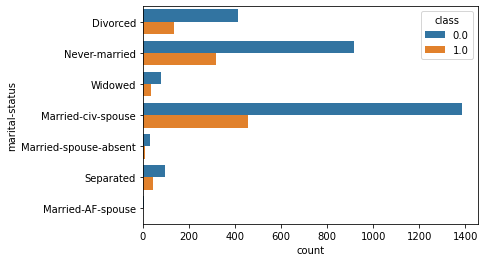

In [21]:
visual.univariate_categ_to_class(data, "marital-status")

Zbavime sa malo pocetnych kategorii a skombinujeme ich vsetky do kategorie "Other"

In [22]:
def marital_status_categories(row):
    
    ms = row["marital-status"]
        
    if ms is not np.nan and ms not in ("Divorced", "Never-married", "Married-civ-spouse"):
        row["marital-status"] = "Other"
        
    return row

In [23]:
data = data.apply(marital_status_categories, axis=1)

Na imputovanie missing values planujem pouzit atribut **relationship**, tak najprv na ten sa taktiez musime pozriet, a jemu znizit pocet kategorii, az potom budeme moct vyberat sposoby, ako imputovat missing values.

#### relationship

Husband           1619
Not-in-family      963
Own-child          601
Unmarried          424
Wife               193
Other-relative     117
Name: relationship, dtype: int64


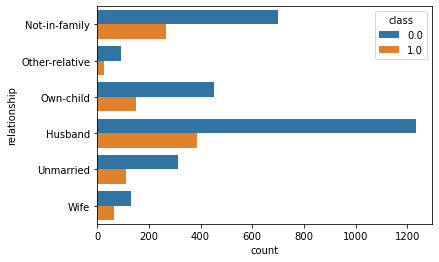

In [24]:
visual.univariate_categ_to_class(data, "relationship")

Znova mozme malopocetne kategorie spojit dokopy a nasledne vykoname bivariate analyzu medzi tymto atributom a marital-status, aby sme urcili, ci sme vybrali vhodny styl kategorizacie.

In [25]:
def relationship_categories(row):
    
    rel = row["relationship"]
        
    if rel is not np.nan and rel not in ("Not-in-family", "Husband", "Own-child"):
        row["relationship"] = "Other"
        
    return row

In [26]:
data = data.apply(relationship_categories, axis=1)

In [27]:
data[["relationship", "marital-status"]].isnull().sum()

relationship      7
marital-status    7
dtype: int64

Teraz sa sustredime na missing values

In [28]:
def custom_cat_impute(data, columns, imputer_type="knn", join=True):

    data = data.copy()
    
    X = data[columns]
    indices = X.index
    
    #do datasetu vkladame ako prvy zaznam same null hodnoty, lebo OrdinalEncoder je celkom hlupy v tomto zmysle pri praci s null hodnotami
    #lebo i ked mu poviete, aby ignoroval null hodnoty, ked ju uvidi po prvy krat, tak sice ju nezakoduje, ale inkrementne encoding hodnoty,
    #co pri iterative imputerovi, kde chcem vediet min hodnotu a max hodnotu encodingu je zle, lebo pokial by som dostal null hodnotu v strede
    #datasetu, tak dana null hodnota zoberie nejaku stredne cislo pre encoding, a zle mi bude vyhodnocovat iterative imputer
    #jednoduchsie je, ked takto feedneme mu hned na zaciatku null hodnoty, vdaka ktorym sa inkrementne hodnota pri encodingu, no uz potom nas
    #nic neprekvapi a hodnoty daneho atributu su cele cisla v rozmedzi medzi 2 a nejakym inym cislom - zatial, co keby sme nedali na zaciatok
    #null hodnotu, tak by sme mali cisla od 1 po ine cislo, kedy by mohlo byt v danom rangy jedno cislo preskocene - nevhodne pre iterativeimputer
    null_values = pd.DataFrame(index=pd.Index([-1]), columns=columns, data=[[np.nan for i in range(len(columns))]])
    X = pd.concat([null_values,X])

    #encodovanie kategorickych atributov
    encoder = ce.ordinal.OrdinalEncoder(handle_missing="return_nan", handle_unknown="return_nan")
    X = encoder.fit_transform(X)
    
    #zbavanie sa null hodnot
    X = X[1:]
    

    if imputer_type == "knn":
        
        imputer = impute.KNNImputer()
        X = imputer.fit_transform(X).round()
    
        
    
    elif imputer_type == "iterative":

        imputer = impute.IterativeImputer(max_iter=20, random_state=42, initial_strategy="most_frequent", 
                                                  min_value=X.min(), max_value=X.max())


        #prvy krat vzdycky hodi iterative imputer nejaky error, ale druhy krat mu to uz nevadi... zaujimave
        try:
            X = imputer.fit_transform(X).round()
        except (ValueError, np.linalg.LinAlgError):
            print("Jeden error bol trapnuty, kedy funkcii vadili NaNs. Tento error je ale divny, lebo mu to vadi", \
                  "len prvy krat, a potom to uz ide...")
            X = imputer.fit_transform(X).round()
    
    
    X = pd.DataFrame(data=X, columns=columns, index=indices)    
    
    #tu uz len zo encodingu chceme naspat stringy - dovodom je ten, ze chceme este hodnoty pouzit pri analyze
    #plus pre niektore atributy budeme chciet skor OneHotEncoding
    if join:
        
        X = encoder.inverse_transform(X)
        data[columns] = X
             
        return data
        
    else:
        return encoder.inverse_transform(X)



Potom mozno najedme dalsie pomocne atributy, ktore nam lepsie pomozu pri estimacii missing values...

In [29]:
data2 = custom_cat_impute(data, ["relationship", "marital-status"])

Takto vyzeraju nase atributy uz so vsetkymi hodnotami

Husband          1619
Not-in-family     963
Other             734
Own-child         601
Name: relationship, dtype: int64


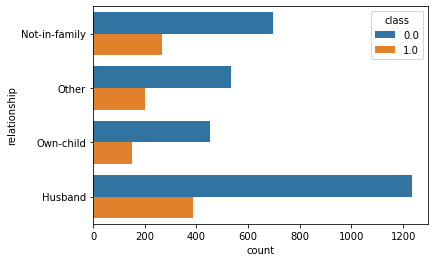

In [30]:
visual.univariate_categ_to_class(data, "relationship")

Married-civ-spouse    1842
Never-married         1232
Divorced               545
Other                  298
Name: marital-status, dtype: int64


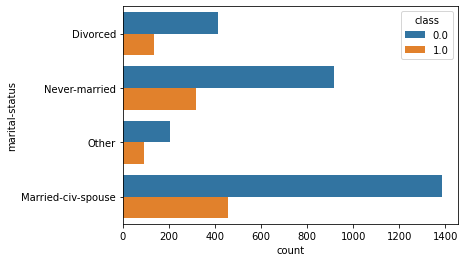

In [31]:
visual.univariate_categ_to_class(data, "marital-status")

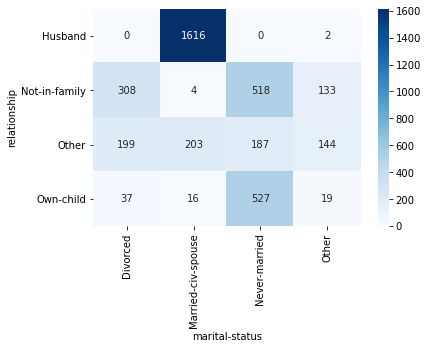

In [32]:
visual.bivar_2cats(data=data, x="marital-status", y="relationship")

### Skupina atributov: occupation, workclass, income, hours-per-week

#### occupation

Upraceme kategorie v tomto atribute. Vsetky mozne hodnoty boli zduplikovane, kedy v jednej variante sa pouzivali "-", zatial co v druhej "_"

In [33]:
data["occupation"] = data["occupation"].apply(lambda row: np.nan if row is not np.nan and row == "?" else row)
data["occupation"] = data["occupation"].apply(lambda row: row.strip().replace("_", "-") if row is not np.nan else row)

Craft-repair         522
Prof-specialty       494
Exec-managerial      480
Adm-clerical         472
Sales                430
Other-service        399
Machine-op-inspct    241
Transport-moving     195
Handlers-cleaners    162
Tech-support         106
Farming-fishing      104
Protective-serv       72
Priv-house-serv       12
Armed-Forces           1
Name: occupation, dtype: int64


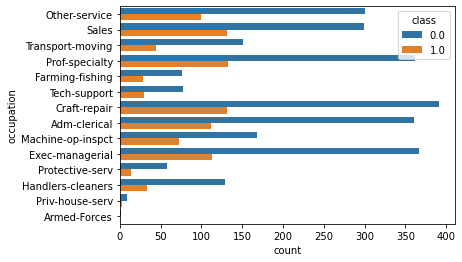

In [34]:
visual.univariate_categ_to_class(data, "occupation")

Malo pocetne hodnoty mozeme mergnut do jednej hodnoty, no ako sme minule vraveli, nemyslime si, ze tento atribut je extra vypovedny pre nasu klasifikacnu ulohu. Avsak mozme ho mierne spracovat a doplnit mu missing values, aby sme neskor v modeli mohli otestovat, ci nam pomaha pri klasifikacii alebo nie. Mergneme 6 najmenej poslednych kategorii do jendej.

In [35]:
def occupation_categories(row):

    occ = row["occupation"]
    
    if occ is not np.nan and occ not in ("Craft-repair", "Prof-specialty", "Exec-managerial", 
                                         "Adm-clerical", "Sales", "Other-service", "Machine-op-inspct", 
                                         "Transport-moving"):
        
        row["occupation"] = "Other"
        
    return row

In [36]:
data = data.apply(occupation_categories, axis=1)

Craft-repair         522
Prof-specialty       494
Exec-managerial      480
Adm-clerical         472
Other                457
Sales                430
Other-service        399
Machine-op-inspct    241
Transport-moving     195
Name: occupation, dtype: int64


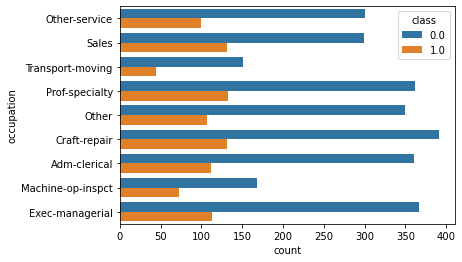

In [37]:
visual.univariate_categ_to_class(data, "occupation")

#### workclass

Private             2754
Self-emp-not-inc     288
Local-gov            252
State-gov            145
Self-emp-inc         130
Federal-gov          119
Never-worked           2
Without-pay            1
Name: workclass, dtype: int64


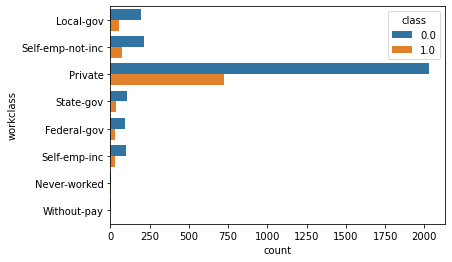

In [38]:
visual.univariate_categ_to_class(data, "workclass")

Tu mergneme vsetky kategorie, ktore nie su private...

In [39]:
def workclass_categories(row):

    wc = row["workclass"]
    
    if wc is not np.nan and wc != "Private":
        row["workclass"] = "Non-private"
        
    return row

In [40]:
data = data.apply(workclass_categories, axis=1)

Private        2754
Non-private     937
Name: workclass, dtype: int64


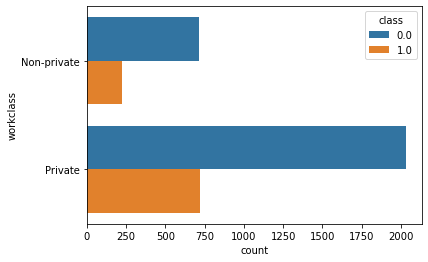

In [41]:
visual.univariate_categ_to_class(data, "workclass")

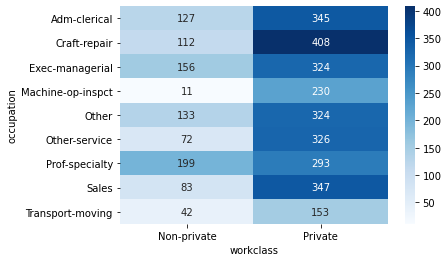

In [42]:
visual.bivar_2cats(data=data, x="workclass", y="occupation")

In [43]:
data[["workclass", "occupation", "income", "hours-per-week"]].isnull().sum()

workclass         233
occupation        234
income              5
hours-per-week      9
dtype: int64

Ako mozno vidiet, je velke mnozstvo NaN hodnot, ktore potrebujeme vyriesit. Mohli by sme ich odstranit, najma pokial by sme nemali ine atributy, podla ktorych by sme mohli imputovat hodnoty, no kvoli tomu, ze je ich tolko vela na imputaciu, tak pouzijeme viacero atributov dokopy, ktore pouzijeme do IterativeImputer na doplnenie missing values.

Este predtym, nez vykoname spominanu imputaciu missing values, treba predspracovat ostatne atributy.

In [44]:
#tato funkcia sluzi len na vizualizaciu aplikacie nonlinearnych transformacii na distribuciu a pocet outlierov
#vdaka nej sa mozme rozhodnut, ci chceme 
def resolving_outliers_transformations(data, column, power_method="yeo-johnson", apply_transformation=None,
                                       figsize=None):
    
    transformers = [
        preprocessing.PowerTransformer(method=power_method),
        preprocessing.QuantileTransformer(output_distribution="normal")
    ]
    
    transf_names = ["PowerTransformer", "QuantileTransformer"]
    
    #uz chcem aplikovat konkretnu kombinaciu
    if apply_transformation is not None:
        
        data = data.copy()
        indices = data.index
        
        idx = transf_names.index(apply_transformation)
        new_data = transformers[idx].fit_transform(data[[column]])
        
        data[column] = pd.Series(new_data.reshape(-1), index=indices)
        
        return data
        
    
    for transf, name in zip(transformers, transf_names):

        transformed = transf.fit_transform(data[[column]])
    
        outliery = identify_outliers(pd.Series(transformed.reshape(-1)))
        
        if name == "PowerTransformer":
            print(name, "| metoda:", power_method)
        else:
            print(name)
            
        print("Pocet outlierov:", len(outliery))
    
        visual.f(figsize)
        sns.distplot(transformed)
        plt.show()
    


In [45]:
#tato funkcia sluzi na zistenie poctu outlierov, pokial distribuciu atributu rozdelime na dvoje, podla hodnoty clz
def outliers_per_distributions_to_class(data, column, clz="class"):
     
    data_y0 = data[data[clz] == 0][column]
    data_y1 = data[data[clz] == 1][column]
    
    out1 = identify_outliers(data_y0)
    out2 = identify_outliers(data_y1)
    
    print("Pocet outlierov pri y=0 je:", len(out1))
    print("Pocet outlierov pri y=1 je:", len(out2))
    
    return len(out1) + len(out2)
    

In [46]:
#tato funkcia sluzi pre zistenie idealnej kombinacie, ako vyriesit outliery pre dolezite atributy, teda tie, ktore 
#maju silnu korelaciu z target atributom 
#typicky to pouzivame prave pri atributoch o glukoze ci kysliku
#vyskusaju sa vsetky kombinacie, teda vyskusa sa na vyriesenie outlierov najprv nonlinearne transformacie, ci odstranenie samotnych
#outlierov. Taktiez sa vyskusa rovno odstranit outliery z novych distribucii, ktore boli vytvorene transformaciami

#apply_combination je metoda, ktorou vykonas urcite operacie, ktore si si vybral pri predchadzajucom volani tejto funkcie
#apply_combination(nazov_transformatora, True/False pre odstranenie outlierov)
def resolving_outliers_transformations_to_class(data, column, clz="class", remove_outliers=True, apply_combination=None,
                                                power_method="yeo-johnson", figsize=None):

    
    transformers = [
        preprocessing.PowerTransformer(method=power_method),
        preprocessing.QuantileTransformer(output_distribution="normal"),
        None
    ]
    
    transformers_names = ["PowerTransformer", "QuantileTransformer", None]
    
    #uz chcem aplikovat konkretnu kombinaciu
    if apply_combination is not None:
        
        #aplikujeme transformaciu
        if apply_combination[0] is not None:

            data = data.copy()
            indices = data.index
            
            idx = transformers_names.index(apply_combination[0])
            
            new_data = transformers[idx].fit_transform(data[[column]])

            data[column] = pd.Series(new_data.reshape(-1), index=indices)
        
            
            #pokial aplikujeme aj odstranovanie outlierov
            if apply_combination[1] == True:
                data = removing_outliers_per_class(data, column, clz=clz, show_plot=False)
        
        #neaplikujeme transformaciu, teda jedine, co robime, je odstranovanie outlierov z distribucii 
        #podla target atributu
        else:
            data = removing_outliers_per_class(data, column, clz=clz, show_plot=False)
        
        
        return data
    
    for transf,name in zip(transformers, transformers_names):
    
        indices = data.index
    
        #pokial aplikujem nejaku transformaciu
        if transf is not None:
            new_data = transf.fit_transform(data[[column]])
            data["new_data"] = pd.Series(new_data.reshape(-1), index=indices)
    
            if name == "PowerTransformer":
                print(name, "| metoda:", power_method)
            else:
                print(name)
                
            pocet_outlierov = outliers_per_distributions_to_class(data, "new_data", clz=clz)
        
            visual.f(figsize)
            visual.univariate_num_to_class(data, "new_data", clz=clz, figsize=figsize, show_regplot=False)
                
        #pokial skusame vymazavat outliery...
        if remove_outliers == True:
            
            #pokial aplikujeme nejaku transformaciu
            if transf is not None:
                print("\n")
                print("Vyskusame odstranit vsetky outliery z danej hornej distribucie")
            
            #pokial neaplikueme ziadnu transformaciu
            else:
                data["new_data"] = data[column]
                pocet_outlierov = outliers_per_distributions_to_class(data, "new_data", clz=clz)
                print("Bez transformacie - vyskusame len odstranit outliery")
                
            
           
            print("Pocet outlierov na odstranenie:", pocet_outlierov)
            removing_outliers_per_class(data, "new_data", clz=clz, figsize=figsize)
    
        print("\n------------------------------------------\n")
    
    data = data.drop(columns=["new_data"])
    
    

In [47]:
def removing_outliers_per_class(data, column, clz="class", show_plot=True, figsize=None):
    
    data = data.copy()
    
    data_y0 = data[data[clz] == 0][column]
    data_y1 = data[data[clz] == 1][column]
        
    idx = identify_outliers(data_y0).index.values
    data = data.drop(index=idx)

    idx = identify_outliers(data_y1).index.values
    data = data.drop(index=idx)
    
    if show_plot == True:
        visual.f(figsize)
        visual.univariate_num_to_class(data, column, show_regplot=False)
    
    return data
    

#### hours-per-week

Pocet outlierov: 1086
Korelacia medzi nasim atributom a y: -0.022582040803000948


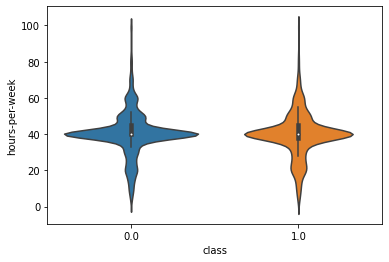

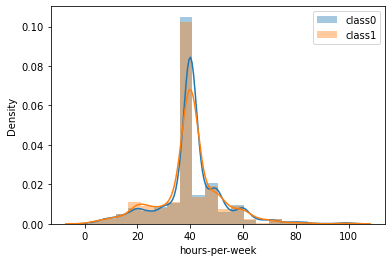

In [48]:
outliery = identify_outliers(data["hours-per-week"])
print("Pocet outlierov:", len(outliery))
visual.univariate_num_to_class(data, "hours-per-week", show_regplot=False)

PowerTransformer | metoda: yeo-johnson
Pocet outlierov: 1086


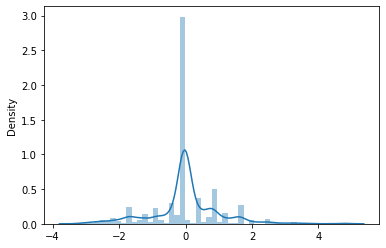

QuantileTransformer
Pocet outlierov: 603


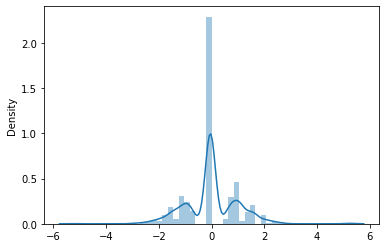

In [49]:
resolving_outliers_transformations(data, "hours-per-week")

Je tu velke mnozstvo outlierov, ktore nemozeme len tak vymazat. Skusal som uz predtym aplikovat na tuto distribuciu viacero transformacii, ako PowerTransform alebo QuantileTransform, aby som transformoval spominane outliery, no bez uspechu. Dovodom, preco je tolko vela dat povazovanych za outlierov je, ze IQR je strasne maly. 

Rozhodol som sa, ze zkategorizujem tento atribut, cim vlastne aj mierne sa zbavim problemu outlierov.

In [50]:
print(data["hours-per-week"].quantile(0.25))
print(data["hours-per-week"].quantile(0.70))
print(data["hours-per-week"].quantile(0.75))

40.0
40.0
45.0


In [51]:
def categorize_hours(row):
    
    hour = row["hours-per-week"]
    
    if math.isnan(hour):
        row["hours-per-week-cat"] = math.nan
    elif hour <= 35:
        row["hours-per-week-cat"] = "<=35"
    elif hour <= 45:
        row["hours-per-week-cat"] = "35< hours <=45"
    elif hour > 45:
        row["hours-per-week-cat"] = ">45"        

    return row
        
data["hours-per-week-cat"] = 0
data = data.apply(categorize_hours, axis=1)

35< hours <=45    2254
<=35               837
>45                824
Name: hours-per-week-cat, dtype: int64


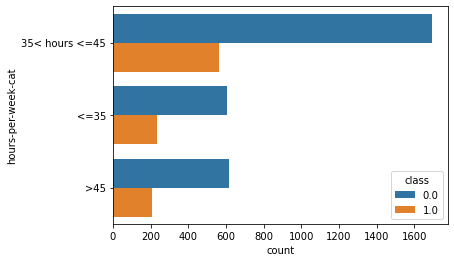

In [52]:
visual.univariate_categ_to_class(data, "hours-per-week-cat")

#### income

Pre tento atribut netreba nic riesit, len imputaciu hodnot, co vsak vykoname spolu s ostatnymi atributmi

<=50K    2959
>50K      960
Name: income, dtype: int64


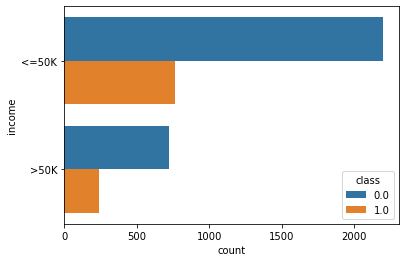

In [53]:
visual.univariate_categ_to_class(data, "income")

#### education 

Tento atribut nam hovori o dosiahnutom vzdelani. Vidime ze je tu vela roznych atributov.

HS-grad         1310
Some-college     854
Bachelors        615
Masters          213
Assoc-voc        161
Assoc-acdm       154
11th             128
10th             117
7th-8th           88
Prof-school       66
12th              58
Doctorate         51
9th               47
5th-6th           36
1st-4th           16
Preschool          6
Name: education, dtype: int64


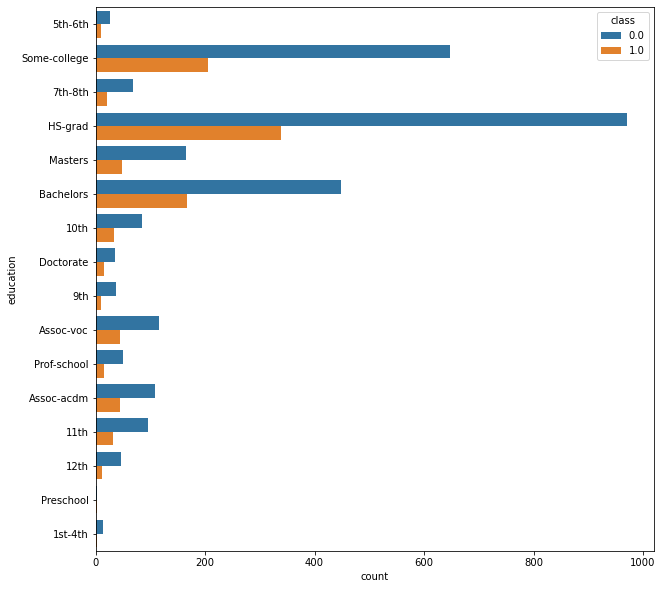

In [54]:
visual.univariate_categ_to_class(data, "education", figsize=(10,10))

Skopirujeme si stlpec education aby sme si ho upravili

In [55]:
data["simple-edu"] = data["education"].copy()

In [56]:
def simplify_education(row):
        
    edu = row["education"]
        
    if edu is np.nan:
        row["simple-edu"] = edu
        
    elif re.match("^([0-9][a-zA-Z])|(1[0-2][a-zA-Z])", edu) or edu == "Preschool":
        row["simple-edu"] = "Attending-school"
        
    elif edu in ["Assoc-acdm", "Assoc-voc", "Prof-school"]:
        row["simple-edu"] = "Edu after HS, no uni"
        
    elif edu in ["Masters", "Doctorate"]:
        row["simple-edu"] = "Masters/Doctorate"
        
    else:
        row["simple-edu"] = row["education"]
    
    return row
        
data = data.apply(simplify_education, axis=1)

Funkcia ktora nam urobi z education a jeho velkeho mnozstva atributov mensiu

In [57]:
data = data.drop('education', axis=1)

In [58]:
data = data.rename(columns = {'simple-edu':'education'})

HS-grad                 1310
Some-college             854
Bachelors                615
Attending-school         496
Edu after HS, no uni     381
Masters/Doctorate        264
Name: education, dtype: int64


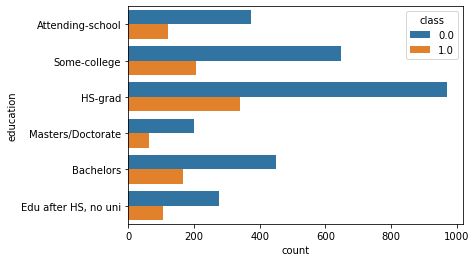

In [59]:
visual.univariate_categ_to_class(data, "education")

Ako mozeme vidiet tak sme si upravili kategorie v education aby sa nam lepsie pracovalo v dalsej fazi zadania

### Atribut education-num

V prvej casti zadania sme sa rozhodli ze missing values nebudeme mazat ale doplnime ich pomocou stlpca education

9.0     1311
10.0     853
13.0     615
14.0     212
11.0     161
12.0     153
7.0      128
6.0      117
4.0       88
15.0      66
8.0       58
16.0      51
5.0       47
3.0       36
2.0       16
1.0        6
Name: education-num, dtype: int64


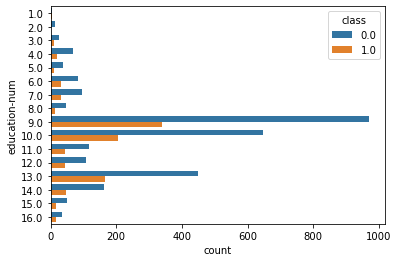

In [60]:
visual.univariate_categ_to_class(data, "education-num")

Korelacia medzi nasim atributom a y: 0.011055958863121947


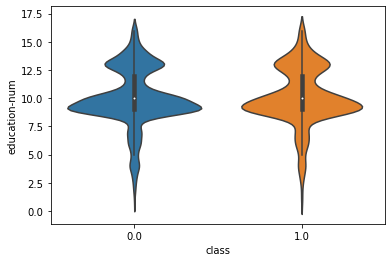

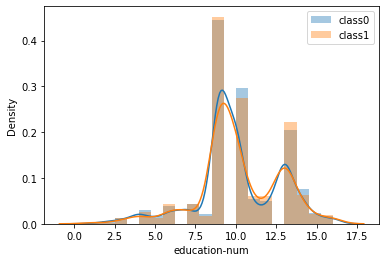

In [61]:
visual.univariate_num_to_class(data, "education-num")

Vidime ze distribucia deti s cukrovkou a bez je skoro rovnaka.

In [62]:
data[["education", "education-num"]].isnull().sum()

education        4
education-num    6
dtype: int64

Overime si pocet missing values

In [63]:
data = custom_cat_impute(data, ["education", "education-num"])

Tieto missing values doplnime pomocou funkcie ktora je vyssie v notebooku

In [64]:
data[["education", "education-num"]].isnull().sum()

education        0
education-num    0
dtype: int64

Ako mozeme vidiet data sa nam podarilo doplnit a v tychto dvoch stplcoch sa nenachadzaju uz ziadne

In [65]:
data = data.drop(columns=["hours-per-week"])
data = custom_cat_impute(data, ["occupation", "workclass", "income", "hours-per-week-cat", "education"])

Podme sa teraz pozriet najma na atributy occupation a workclass, ktorym velkme mnozstvo hodnot chybalo

Prof-specialty       623
Craft-repair         547
Other                504
Exec-managerial      480
Adm-clerical         480
Sales                430
Other-service        399
Machine-op-inspct    241
Transport-moving     220
Name: occupation, dtype: int64


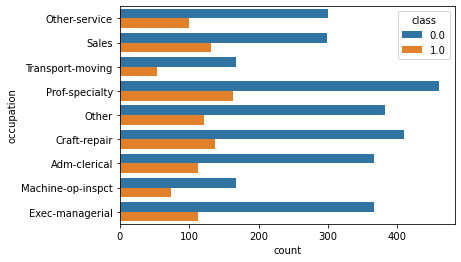

In [66]:
visual.univariate_categ_to_class(data, "occupation")

Private        2981
Non-private     943
Name: workclass, dtype: int64


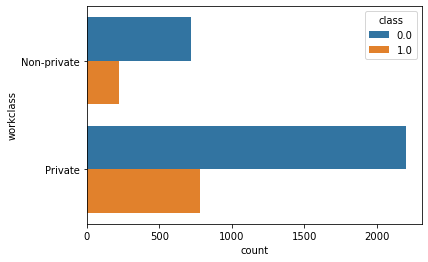

In [67]:
visual.univariate_categ_to_class(data, "workclass")

### Atribut native_country

Atribut ktory nam hovori o krajine povodu daneho pacienta, vidime ze takto to nechat nemozeme. Napadlo nas riesenie ze urobime len 2 skupiny. Jedna bude Unted States a v do dalsej dame vsetky ostatne krajiny

United-States         3520
Mexico                  73
Philippines             28
El-Salvador             18
Puerto-Rico             15
Canada                  14
England                 13
India                   12
Cuba                    12
Germany                 12
Vietnam                 10
Italy                    9
South                    8
China                    8
Iran                     7
Jamaica                  7
Guatemala                7
Taiwan                   7
Columbia                 6
Japan                    6
Dominican-Republic       5
Poland                   4
Honduras                 4
Portugal                 4
Peru                     4
Hong                     3
Thailand                 3
Haiti                    3
France                   3
Ecuador                  2
Ireland                  2
Scotland                 2
Trinadad&Tobago          2
Yugoslavia               2
Cambodia                 1
Greece                   1
Laos                     1
N

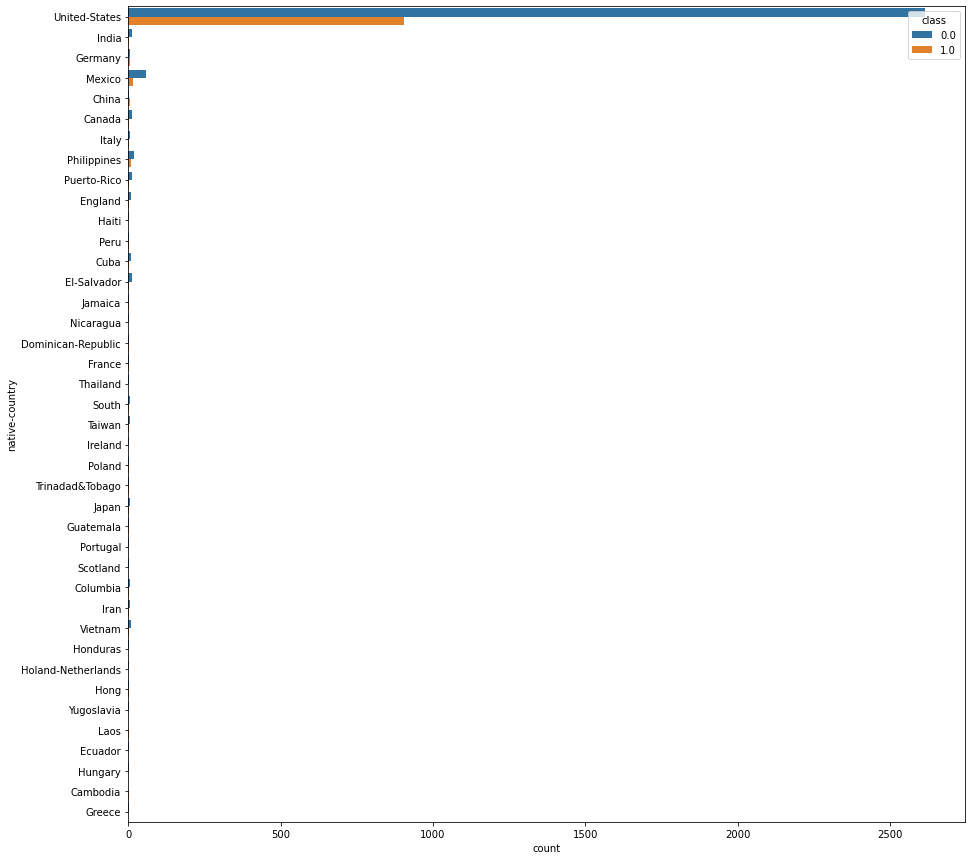

In [68]:
visual.univariate_categ_to_class(data, "native-country", figsize = (15,15))

In [69]:
def native_country_categories(row):

    nc = row["native-country"]
    
    if nc is not np.nan and nc not in ("United-States"):
        row["native-country"] = "Other"
        
    return row

Funkcia ktora nam zabezpeci aby sme v stplci native country mali len United States a Other

In [70]:
data = data.apply(native_country_categories, axis=1)

United-States    3520
Other             321
Name: native-country, dtype: int64
Pocet percent ludi z USA: 0.8970438328236493


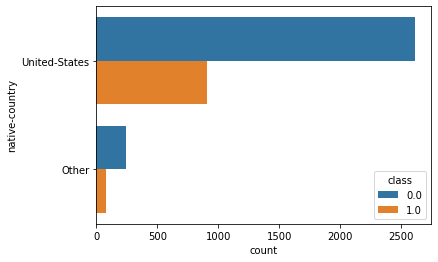

In [71]:
visual.univariate_categ_to_class(data, "native-country")
print("Pocet percent ludi z USA:", len(data[data["native-country"] == "United-States"]) / len(data))

Tento atribut, aj po mergnuti vsetkych krajin do jednej, neratajuc USA, stale drtiva vacsina je z USA, a teda ma dany atribut malu varianciu, tak ho vymazeme...

In [72]:
data = data.drop(columns=["native-country"])

### Atribut race

V prvej fáze sme zistili že početnosť white previšuje všetký ostatné mnohonásobne. Rozhodli sme sa zvyšné rasy mergnut do jednej ktorú sme pomenovali "other"

White                 3352
Black                  382
Asian-Pac-Islander     127
Amer-Indian-Eskimo      33
Other                   26
Name: race, dtype: int64


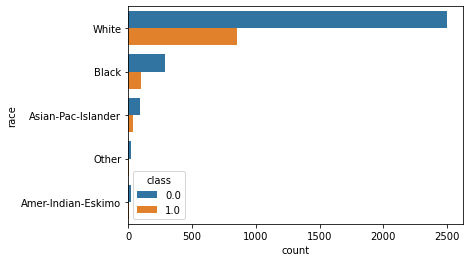

In [73]:
visual.univariate_categ_to_class(data, "race")

In [74]:
def race_categories(row):
    
    race = row["race"]
        
    if race is not np.nan and race not in ("White"):
        row["race"] = "Other"
        
    return row

Funkcia ktora nam mergne skupiny do uz len do dvoch.

In [75]:
data = data.apply(race_categories, axis=1)

White    3352
Other     568
Name: race, dtype: int64
Pocet percent bielych ludi: 0.854230377166157


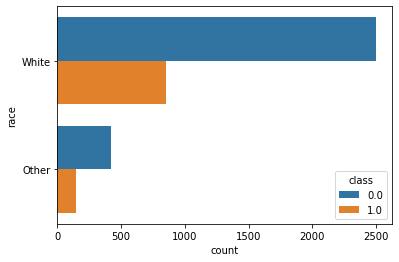

In [76]:
visual.univariate_categ_to_class(data, "race")
print("Pocet percent bielych ludi:", len(data[data["race"] == "White"]) / len(data))

Ako v pripade native-country, tak tento atribut mozeme vymazat, lebo ma malu varianciu.

In [77]:
data = data.drop(columns=["race"])

### Atribut adress

In [78]:
len(data["address"].unique())

3924

In [79]:
data[['street','city']] = data.address.str.split('\r\n', expand = True)

In [80]:
data = data.drop(columns=["address"])

Rozparsujeme si atribut addressdo dvoch novych atributov 
Nasledne si overime ci nam chybaju nejake data

In [81]:
data.street.isnull().sum()

0

In [82]:
data.city.isnull().sum()

0

Pozrieme sa na mesto a stat ci maju vypovednu hodnotu

# FEEDBACK -------------------------------

chybaju ti tu nejake tie .value_counts(), kde by si ukazal pocetnosti. Pokial su dost pocetne nejake hodnoty, resp. je ich malo tych hodnot, tak sa to moze aj hodit do grafu. Nasledne z toho grafu mozes vycitat, ci pomer cukrovkarov a necukrovkarov je nejaky nezvycajny oproti typickemu datasetu. Tento pomer vsak je vhodne len pozerat na vela-pocetnych hodnotach, lebo za to, ze 5 ludia su z nejakeho statu a vsetci maju cukrovku, nic nevravi. Ale pokial ich je 50, a tam maju vsetci cukrovku, to uz je nieco zaujimaveho :D

In [83]:
data[['city1','state1']] = data.city.str.split(',', expand = True)

In [84]:
data[['state','postcode']] = data.state1.str.split(expand = True)

In [85]:
data.drop(['street', 'city', 'state1', 'postcode'], axis=1, inplace=True)

In [86]:
data.rename(columns = {'city1':'city'}, inplace = True)

In [87]:
data["city"].value_counts()

New Michael          7
New David            6
East Michael         6
New Christopher      6
Smithmouth           5
                    ..
New Samuelchester    1
South Rhonda         1
Brianbury            1
South Kari           1
FPO AA 62214         1
Name: city, Length: 3501, dtype: int64

Tento atribut cely mazeme nie su tam ziadne velko pocetne udaje pri jednom meste

In [88]:
data.drop(['city'], axis=1, inplace=True)

In [89]:
data["state"].value_counts()

AR    89
WY    86
NC    86
AK    84
IN    83
OH    82
GA    81
NH    81
TN    80
MS    79
HI    78
MO    78
WV    77
NE    76
SD    76
SC    75
NM    73
AZ    73
IA    70
OK    70
LA    69
ND    69
PA    68
AL    67
UT    67
RI    67
VT    67
KY    65
MI    65
CT    65
MD    64
MA    64
TX    63
FL    62
OR    61
CO    61
WI    60
DC    60
VA    60
WA    60
KS    60
CA    60
NY    60
DE    59
IL    58
ME    58
ID    57
MN    57
NJ    56
NV    55
MT    51
Name: state, dtype: int64

AR    89
WY    86
NC    86
AK    84
IN    83
OH    82
GA    81
NH    81
TN    80
MS    79
HI    78
MO    78
WV    77
NE    76
SD    76
SC    75
NM    73
AZ    73
IA    70
OK    70
LA    69
ND    69
PA    68
AL    67
UT    67
RI    67
VT    67
KY    65
MI    65
CT    65
MD    64
MA    64
TX    63
FL    62
OR    61
CO    61
WI    60
DC    60
VA    60
WA    60
KS    60
CA    60
NY    60
DE    59
IL    58
ME    58
ID    57
MN    57
NJ    56
NV    55
MT    51
Name: state, dtype: int64


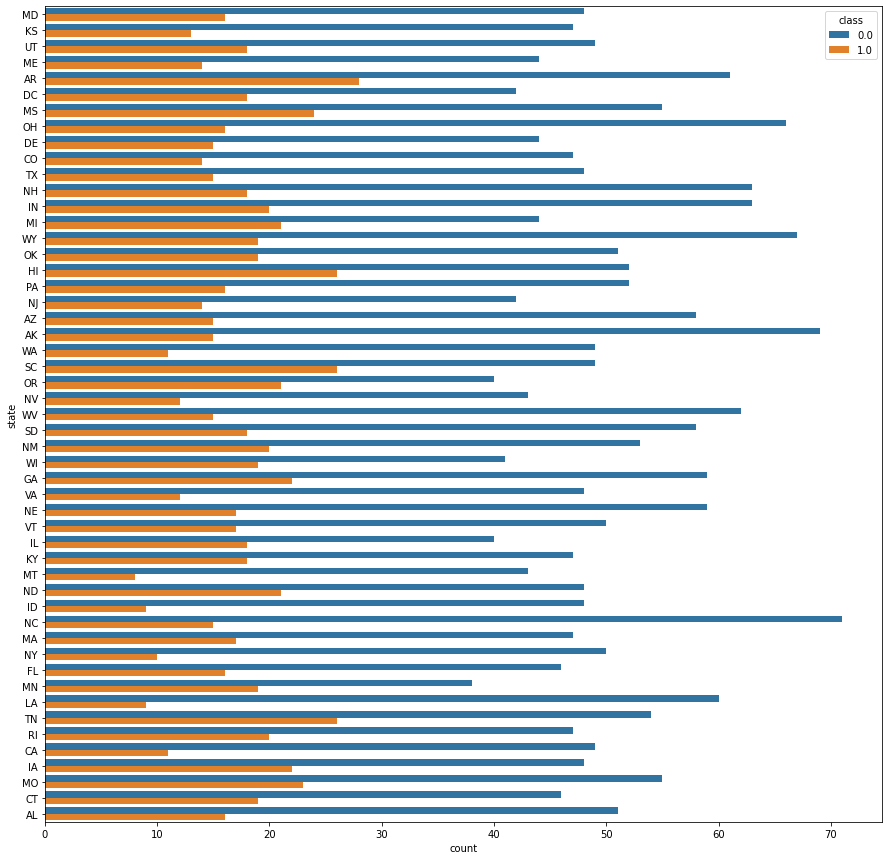

In [90]:
visual.univariate_categ_to_class(data, "state", figsize=(15,15))

Na toto sa prosim mrkni ci tu je nieco zaujimave, ja osobne si myslim ze nie

In [91]:
data.drop(['state'], axis=1, inplace=True)

### Atribut date_of_birth

V 1 zadani sme si vsimli ze udaj age ma v sebe zle hodnoty. Preto sme sa rozdhodli pouzit date_of_birth ako atribut podla ktoreho si budeme pocitat vek pacienta

In [92]:
import re
dates = []

for index,row in data.iterrows():
    dates.append(re.sub('\d', '*',  row['date_of_birth']))
    
dates = list(set(dates))
dates

['****-**-** **:**:**',
 '****-**-**',
 '**-**-**',
 '****/**/**',
 '****-**-** ** ** **',
 '**/**/****']

Vidime ze v date_of_birth su rozne formaty datumov. V nasledujucej casti ich upravime na rovnaky format

In [93]:
import re
from datetime import datetime

for index,row in data.iterrows():
    line = row['date_of_birth']
    if re.match(r"^\d{2}-\d{2}-\d{2}$", line):
        regex1 = line[0:2]
        regex2 = line[3:5]
        regex3 = line[6:8]
        
        verbose = False
        if (verbose == True):
            if (int(regex1) > 31):
                print('Prvy udaj > 31: ',regex1)
            if (int(regex2) > 31):
                print('Druhy udaj > 31: ',regex2)
            if (int(regex3) > 31):
                print('Treti udaj > 31: ',regex3)

Overili sme si ze prvy udaj je rok, upravime to tak ze skrateny rok nahradime celym rokom. Napr. 67 - 1967

In [94]:
data['date_of_birth'] = data['date_of_birth'].map(lambda x: x[:10])

Odstranili sme cas

In [95]:
import re
dates = []

for index,row in data.iterrows():
    dates.append(re.sub('\d', '*',  row['date_of_birth']))
    
dates = list(set(dates))
dates

['**-**-**', '****/**/**', '**/**/****', '****-**-**']

Mame 4 rozne formaty datumov

In [96]:
import re
from datetime import datetime

for index,row in data.iterrows():
    line = row['date_of_birth']
    dateObj = None
    if re.match(r"^\d{2}-", line):
        newDate = '19' + line
        dateObj = datetime.strptime(newDate,'%Y-%m-%d')
    elif re.match(r"^\d{4}-", line):
        dateObj = datetime.strptime(line,'%Y-%m-%d')
    elif re.match(r"^\d{4}/", line):
        dateObj = datetime.strptime(line,'%Y/%m/%d')
    elif re.match(r"^\d{2}/", line):
        dateObj = datetime.strptime(line,'%d/%m/%Y')
    data.at[index,'date_of_birth'] = dateObj.strftime('%d-%m-%Y')

In [97]:
data['date_of_birth'].head()

0    27-12-1962
1    22-05-1969
2    26-07-1994
3    16-04-1977
4    11-12-1969
Name: date_of_birth, dtype: object

Datum sme nakoniec upravili do jedneho formatu pre vsetky zaznami

In [98]:
data["date_of_birth"].isnull().sum()

0

Overili sme si ci mame nejake missing values. Nemame ziadne

### Atribut age

In [99]:
data.age.unique()

array([   56,    50,    25,    42, -4900,    47,    74,    60,    72,
          61,    43,    52,    70,    57,    63,    54,    67, -3700,
          45,    75,    36,    41,    64,    46,    33,    77,    48,
        6900,    30,    37, -5200,    28,    65, -5800,    59,    68,
          69,    66,    53,    22, -5700, -4300,    58,    51,    38,
          29,    39,    35, -5400,    49,    17,    31,  5000,    62,
        6100,  5100,    44,    34,  5800,  3700, -4400, -5600,    -1,
        5300, -5300,  5400, -6900,    55,  4700,  7800,  6400, -6800,
          40, -5100,    73,  5200, -4800, -4000,  5900,  3200,  4500,
          26, -6200,  7100,  5600, -6400,  4000,  5700,    79,    90,
        7000,  6800,    82,     3,    23,    19,    81,  3600, -6700,
          80,     7, -3300,    76,    27,    71,    83, -3800, -5500,
       -5900, -4600,  4200,  4800,    16, -8600, -6500,    84,  6200,
       -8000, -5000,  4300,    18, -6000,  2900, -4500,  3800,    32,
          24,    21,

Vidime ze age ma nekorektne hodnoty, tento stlpec si dropneme a na zaklade date_of_birth si vytvorime novy age kde budu hodnoty spravne. Mohli by sme pouzit approach, ktory sme pouzivali v analyze, kedy velke cisla su len vynasobene 100, resp. -100, kedy sme aj na dany approach spravili hypotezu, ktoru sme nevedeli vyvratit - co je dobre, no na druhej strane mame atribut, ktory neobsahuje ziadne nullove hodnoty, tak preco ho nevyuzit.

# FEEDBACK -------------------------------------------------------------------

Chcem, aby si nedropol cely age, ale iba nastalil tie zle hodnoty (velmi velke/male) na np.nan, a nasledne dane hodnoty imputoval podla datumu

In [100]:
data = data.drop(['age'], axis=1)

In [101]:
def calculate_age(born):
    born = datetime.strptime(born, "%d-%m-%Y").date()
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

Funkcia na vypocet veku z datumu narodenia

In [102]:
data['age'] = data['date_of_birth'].apply(calculate_age)

60
Korelacia medzi nasim atributom a y: 0.3639790189191095


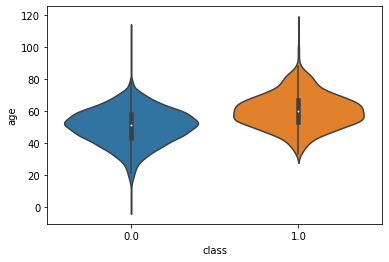

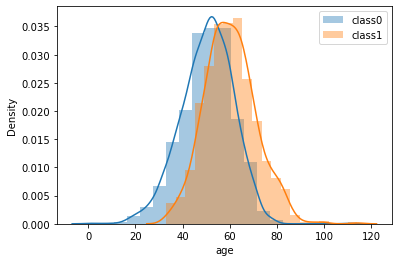

In [103]:
outliers = identify_outliers(data["age"])
print(len(outliers))

visual.univariate_num_to_class(data, "age")

Tento atribut je na hrane dolezitosti podla korelacie voci target atributu, a tak nevieme presne, ako sa mame k nemu spravat. Sice nema najvyssiu korelaciu, ale podla grafu vyssie, je mozne dany atribut povazovat za 2 distribucie na zaklade target atributu. Tak mozme vyskusat obidva approachy, pricom hladame taky, kde budem najmenej outlierov, aby sme vela zaznamov nemuseli vymazavat.

PowerTransformer | metoda: yeo-johnson
Pocet outlierov: 60


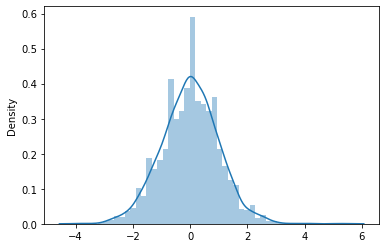

QuantileTransformer
Pocet outlierov: 33


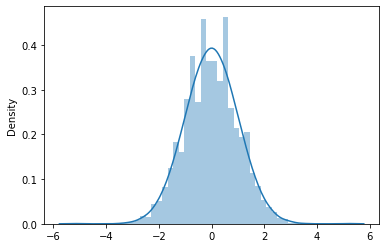

In [104]:
resolving_outliers_transformations(data, "age")

PowerTransformer | metoda: yeo-johnson
Pocet outlierov pri y=0 je: 16
Pocet outlierov pri y=1 je: 6
Korelacia medzi nasim atributom a y: 0.3665499797047126


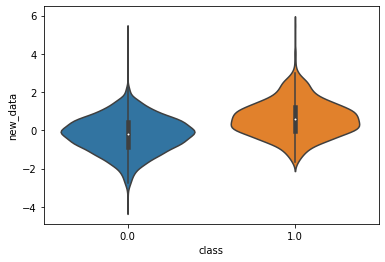

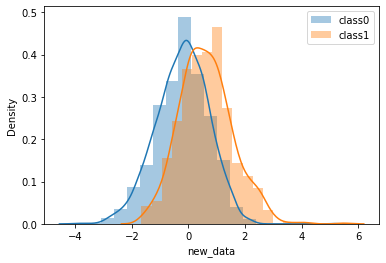



Vyskusame odstranit vsetky outliery z danej hornej distribucie
Pocet outlierov na odstranenie: 22
Korelacia medzi nasim atributom a y: 0.36442386231871104


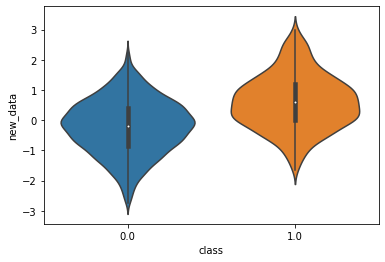

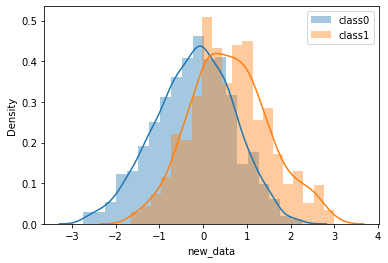


------------------------------------------

QuantileTransformer
Pocet outlierov pri y=0 je: 10
Pocet outlierov pri y=1 je: 2
Korelacia medzi nasim atributom a y: 0.3661489069166842


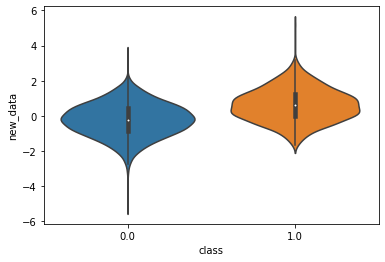

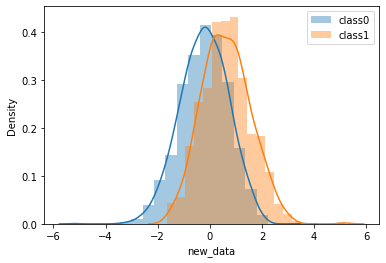



Vyskusame odstranit vsetky outliery z danej hornej distribucie
Pocet outlierov na odstranenie: 12
Korelacia medzi nasim atributom a y: 0.3661837266621366


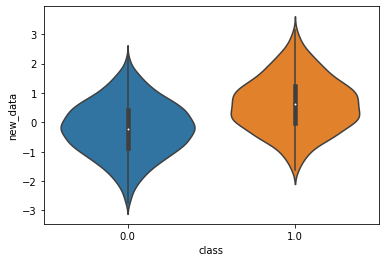

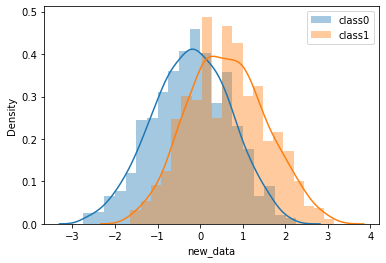


------------------------------------------

Pocet outlierov pri y=0 je: 24
Pocet outlierov pri y=1 je: 5
Bez transformacie - vyskusame len odstranit outliery
Pocet outlierov na odstranenie: 29
Korelacia medzi nasim atributom a y: 0.3620087013518318


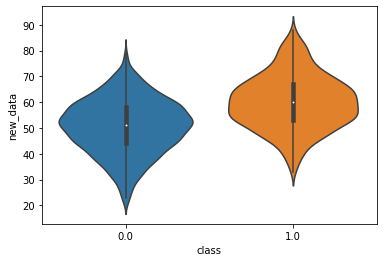

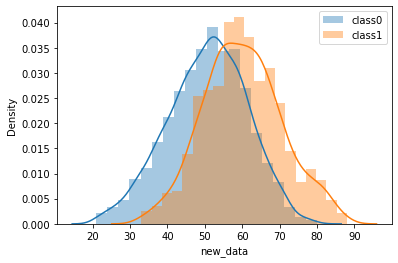


------------------------------------------



In [105]:
resolving_outliers_transformations_to_class(data, "age")

Vidime, ze najmenej outlierov dosahujeme, pokial pouzijeme quantile transformaciu. Nasledne vymazeme dane outliery...

In [106]:
data2 = resolving_outliers_transformations_to_class(data, "age", apply_combination=("QuantileTransformer", True))

### sex

Male      2627
Female    1297
Name: sex, dtype: int64


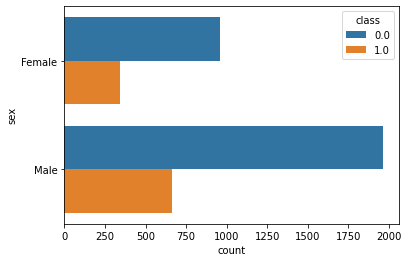

In [107]:
visual.univariate_categ_to_class(data, "sex")

## medical_info 

Ako vieme uz z minulej casti, v tomto atribute su ulozene 4 atributy, ktore sa sustreduju na namerane hodnoty mnozstva kyslika v krvi pacientov.

Najprv budeme riesit outliery jednotlivych atributov, a potom spolu naraz im vyriesime missing values cez IterativeImputator

In [108]:
data["mean_oxygen"] = np.nan
data["std_oxygen"] = np.nan
data["kurtosis_oxygen"] = np.nan
data["skewness_oxygen"] = np.nan

In [109]:
def get_oxygen_stats(row):
    
    string = row["medical_info"]
    
    if string is np.nan:
        return row
    
    string = string.replace("\'", "\"")
    di = json.loads(string)
    
    for k in di.keys():
        row[k] = float(di[k])
        
    return row

In [110]:
data = data.apply(get_oxygen_stats, axis=1)
data = data.drop(columns=["medical_info"])

Na zaciatok sa pozrieme na vztahy/korelacie medzi danymi atributmi, predtym nez ich ideme spracuvat

In [111]:
oxygen_attributes = ["mean_oxygen", "std_oxygen", "skewness_oxygen", "kurtosis_oxygen"]

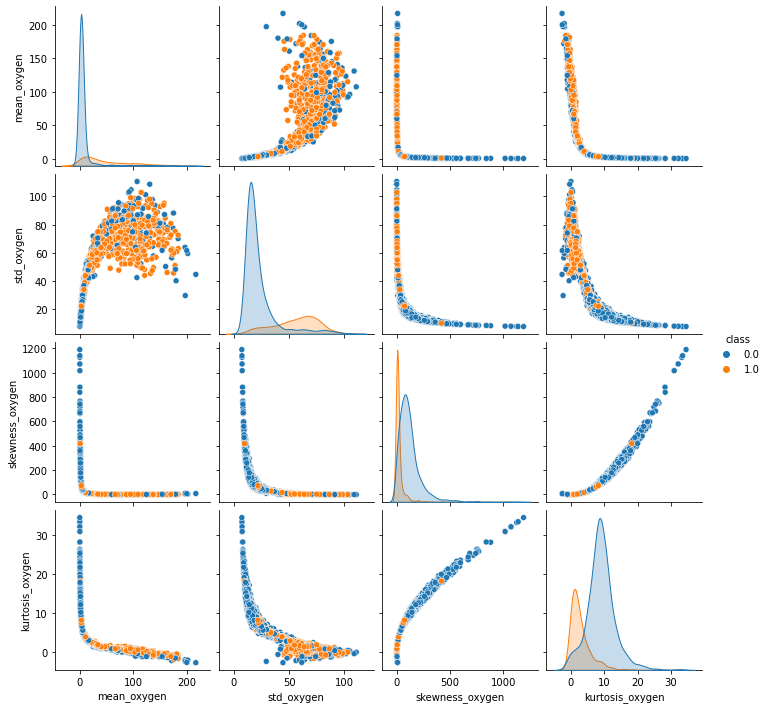

In [112]:
sns.pairplot(data[oxygen_attributes+["class"]], hue="class")

<AxesSubplot:>

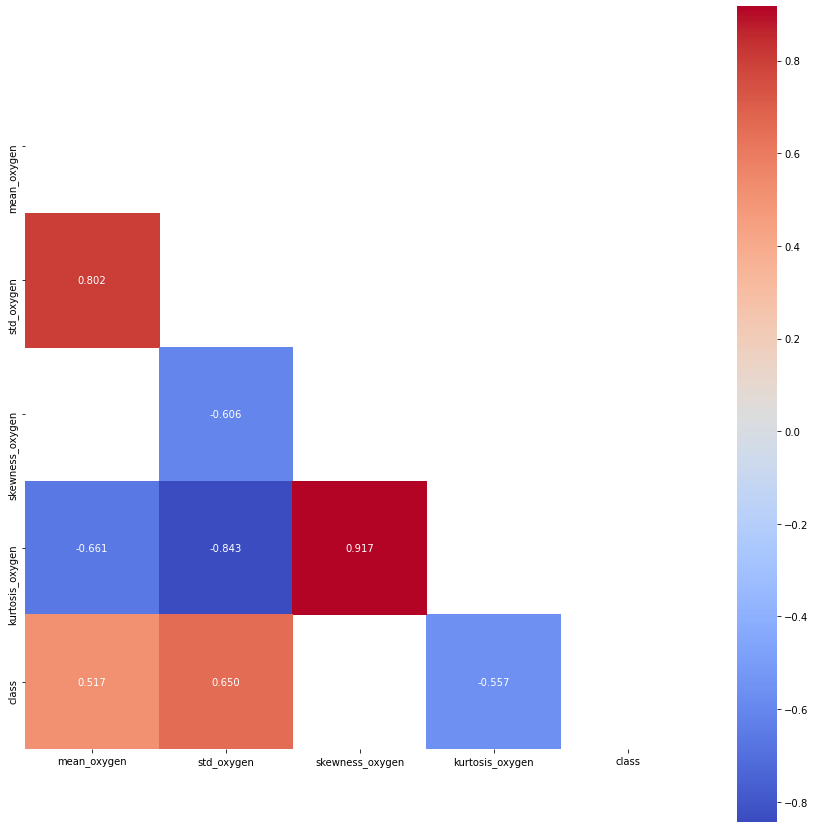

In [113]:
korelacie = data[oxygen_attributes+["class"]].corr()

maska = visual.heatmap_mask(korelacie, threshold=0.5)

visual.f(figsize=(15,15))
sns.heatmap(data=korelacie, cmap="coolwarm", annot=True, fmt=".3f", square=True, mask=maska)

#### mean_oxygen

Pocet outlierov: 693
Korelacia medzi nasim atributom a y: 0.5172635777288903


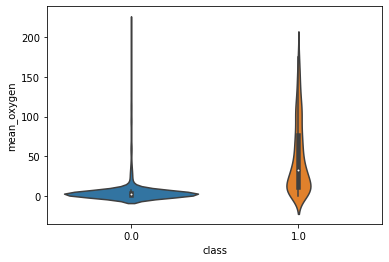

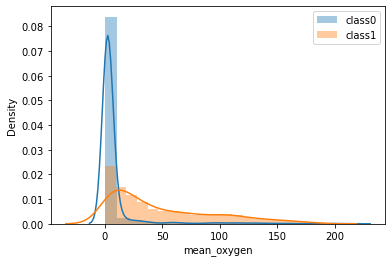

In [114]:
outliers = identify_outliers(data["mean_oxygen"])
print("Pocet outlierov:", len(outliers))

visual.univariate_num_to_class(data, "mean_oxygen", show_regplot=False)

Klucom pri spracovavani outlierov pri vacsine tychto medicinskych merani, je rozdelit si dany atribut podla target atributu. Ako mozno vidiet vyssie, tak vidime, ze dane distribucie hodnot tohto atributu podla hodnoty class su radikalne odlisne.

In [115]:
outliers_per_distributions_to_class(data, "mean_oxygen")

Pocet outlierov pri y=0 je: 358
Pocet outlierov pri y=1 je: 7


365

Uz len tymto rozdelenim hodnot do dvoch distribucii sme sa zbavili polovice outlierov. Keby sme to tak nespravili, tak velke mnozstvo cukrovkarov by bolo odstranenych, i ked oni sami, ked ich porovname k ostatnym cukrovkarom, nie su outliermi.

PowerTransformer | metoda: yeo-johnson
Pocet outlierov pri y=0 je: 189
Pocet outlierov pri y=1 je: 64
Korelacia medzi nasim atributom a y: 0.6424586245681683


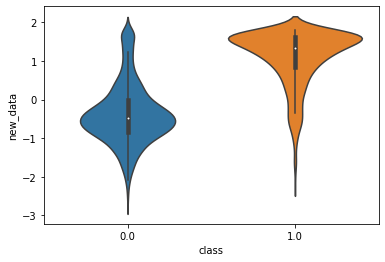

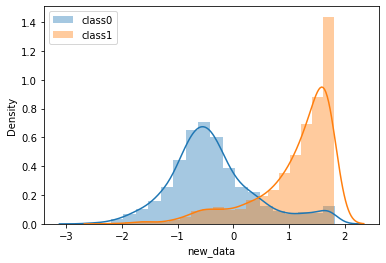



Vyskusame odstranit vsetky outliery z danej hornej distribucie
Pocet outlierov na odstranenie: 253
Korelacia medzi nasim atributom a y: 0.7826942308453162


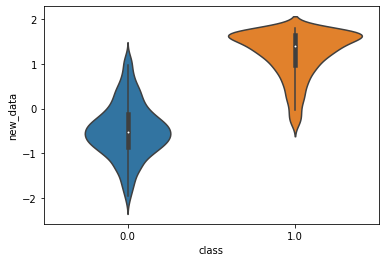

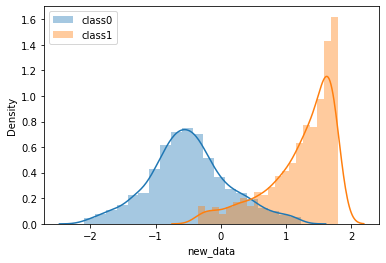


------------------------------------------

QuantileTransformer
Pocet outlierov pri y=0 je: 61
Pocet outlierov pri y=1 je: 58
Korelacia medzi nasim atributom a y: 0.5675786248077387


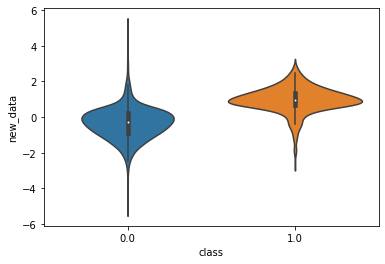

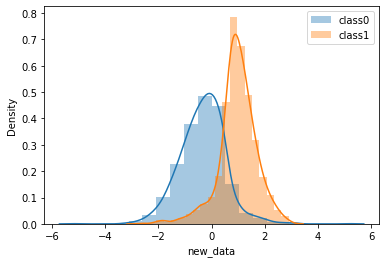



Vyskusame odstranit vsetky outliery z danej hornej distribucie
Pocet outlierov na odstranenie: 119
Korelacia medzi nasim atributom a y: 0.6369240928573673


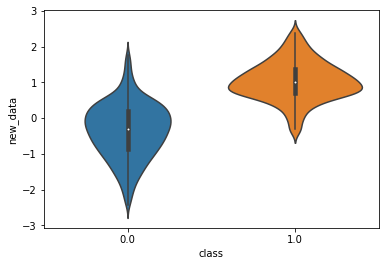

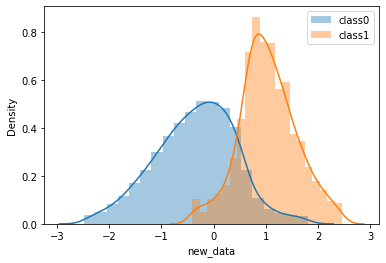


------------------------------------------

Pocet outlierov pri y=0 je: 358
Pocet outlierov pri y=1 je: 7
Bez transformacie - vyskusame len odstranit outliery
Pocet outlierov na odstranenie: 365
Korelacia medzi nasim atributom a y: 0.6576775365977274


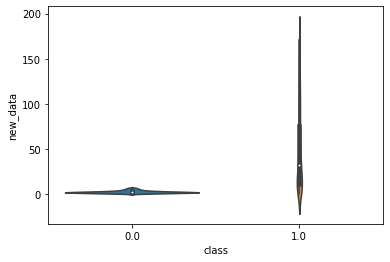

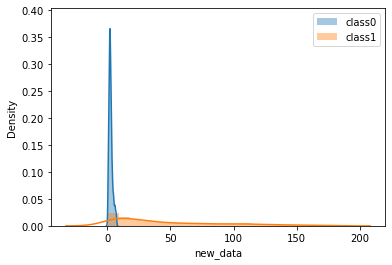


------------------------------------------



In [116]:
resolving_outliers_transformations_to_class(data, "mean_oxygen")

Po vyskusani viacerych kombinacii sme dosli k zaveru, ze pouzitie PowerTransform a nasledne odstranenie outlierov je navhodnejsi sposob, ako sa zbavit outlierov a popritom ziskat najvyssiu korelaciu medzi tymto atributom a target atributom

Korelacia medzi nasim atributom a y: 0.7826942308453162


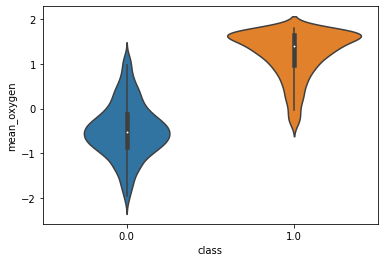

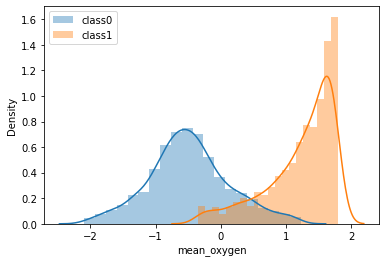

In [117]:
data = resolving_outliers_transformations_to_class(data, "mean_oxygen", apply_combination=("PowerTransformer", True))
visual.univariate_num_to_class(data, "mean_oxygen", show_regplot=False)

#### std_oxygen

Pocet outlierov: 214
Korelacia medzi nasim atributom a y: 0.8290700715754457


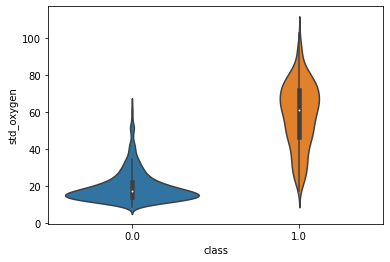

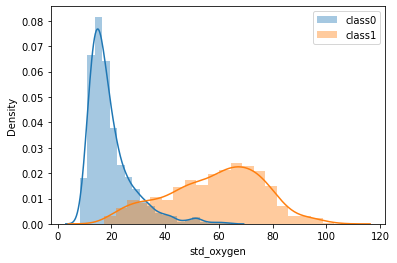

In [118]:
outliers = identify_outliers(data["std_oxygen"])
print("Pocet outlierov:", len(outliers))

visual.univariate_num_to_class(data, "std_oxygen", show_regplot=False)

Pre vsetky atributy kyslika, ako aj glukozy aplikujeme rovnaku proceduru hladania approachu na odstranenie outlierov. Kedze tieto medicinske zaznamy maju velku korelaciu s target atributom "class", tak uvazujeme nad danym atributom, ze je tvoreny 2 distribuciami podla hodnoty "class"

PowerTransformer | metoda: yeo-johnson
Pocet outlierov pri y=0 je: 0
Pocet outlierov pri y=1 je: 63
Korelacia medzi nasim atributom a y: 0.7514757070426079


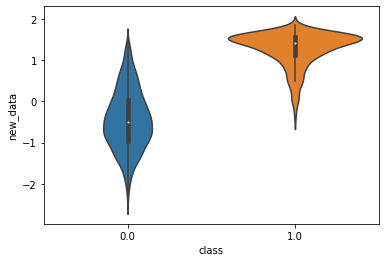

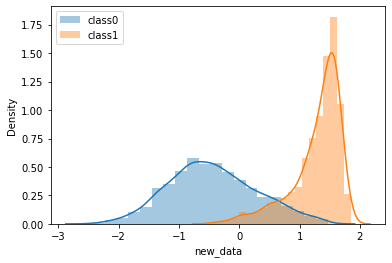



Vyskusame odstranit vsetky outliery z danej hornej distribucie
Pocet outlierov na odstranenie: 63
Korelacia medzi nasim atributom a y: 0.7665379361298532


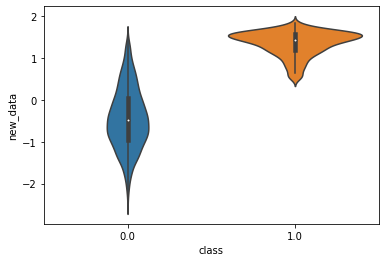

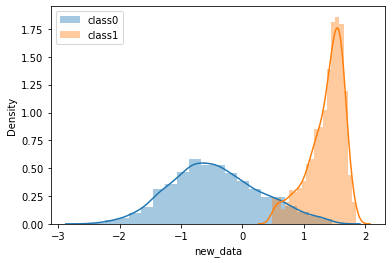


------------------------------------------

QuantileTransformer
Pocet outlierov pri y=0 je: 25
Pocet outlierov pri y=1 je: 19
Korelacia medzi nasim atributom a y: 0.7011287987273416


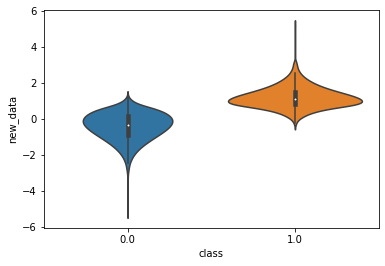

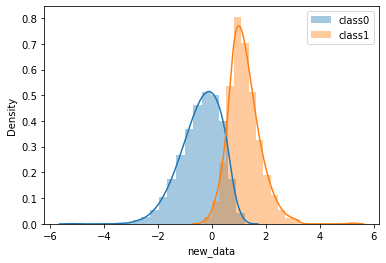



Vyskusame odstranit vsetky outliery z danej hornej distribucie
Pocet outlierov na odstranenie: 44
Korelacia medzi nasim atributom a y: 0.7081901662595874


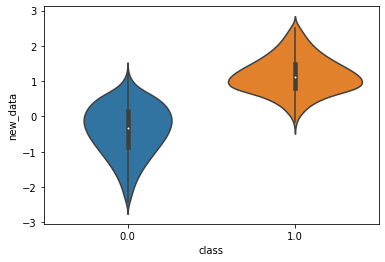

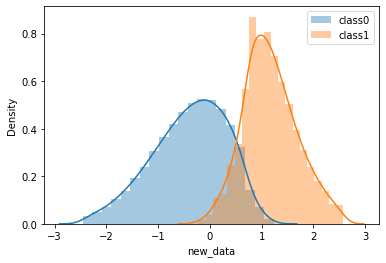


------------------------------------------

Pocet outlierov pri y=0 je: 166
Pocet outlierov pri y=1 je: 0
Bez transformacie - vyskusame len odstranit outliery
Pocet outlierov na odstranenie: 166
Korelacia medzi nasim atributom a y: 0.8682327787656314


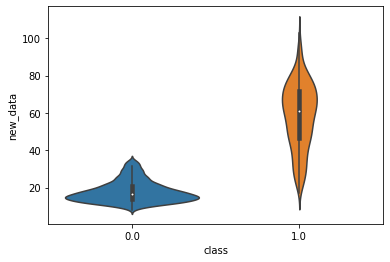

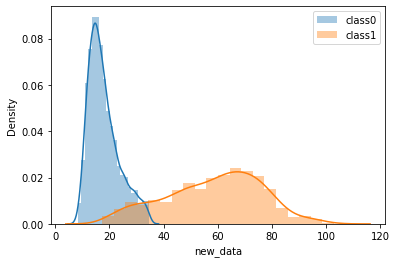


------------------------------------------



In [119]:
resolving_outliers_transformations_to_class(data, "std_oxygen")

V tomto pripade, ziadna transformacia nezlepsuje korelaciu, a tak len odstranime outliery z datasetu

Korelacia medzi nasim atributom a y: 0.8682327787656314


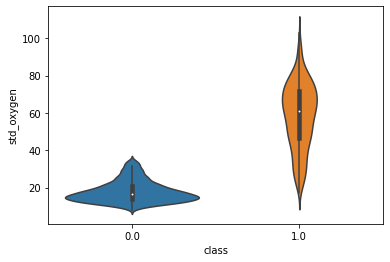

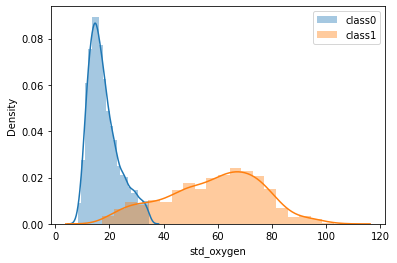

In [120]:
data = resolving_outliers_transformations_to_class(data, "std_oxygen", apply_combination=(None, True))
visual.univariate_num_to_class(data, "std_oxygen", show_regplot=False)

#### skewness_oxygen

Pocet outlierov: 151
Korelacia medzi nasim atributom a y: -0.5418146632710122


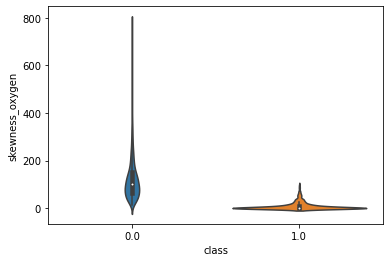

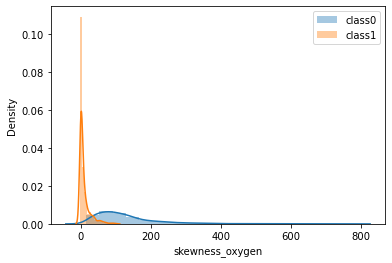

In [121]:
outliers = identify_outliers(data["skewness_oxygen"])
print("Pocet outlierov:", len(outliers))

visual.univariate_num_to_class(data, "skewness_oxygen", show_regplot=False)

PowerTransformer | metoda: yeo-johnson
Pocet outlierov pri y=0 je: 65
Pocet outlierov pri y=1 je: 10
Korelacia medzi nasim atributom a y: -0.7822914720923217


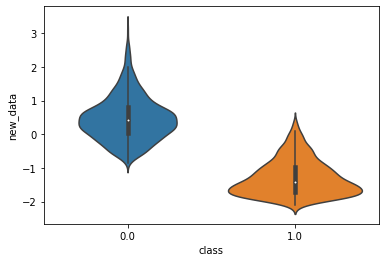

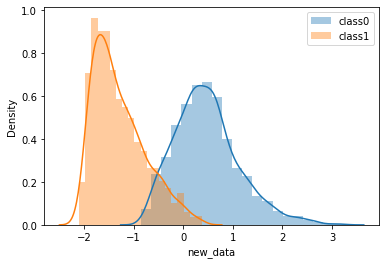



Vyskusame odstranit vsetky outliery z danej hornej distribucie
Pocet outlierov na odstranenie: 75
Korelacia medzi nasim atributom a y: -0.8074705821985075


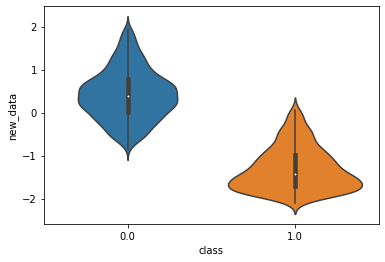

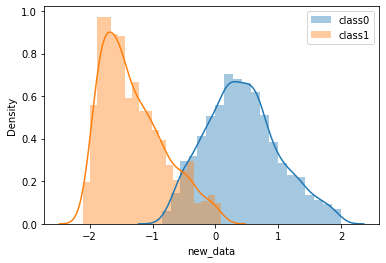


------------------------------------------

QuantileTransformer
Pocet outlierov pri y=0 je: 25
Pocet outlierov pri y=1 je: 28
Korelacia medzi nasim atributom a y: -0.7200214865784271


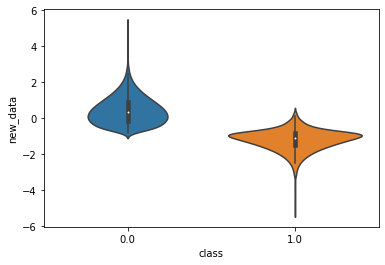

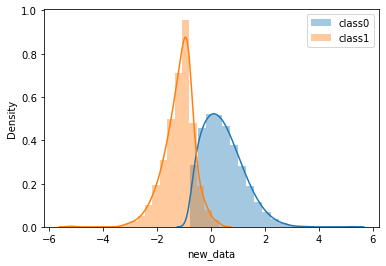



Vyskusame odstranit vsetky outliery z danej hornej distribucie
Pocet outlierov na odstranenie: 53
Korelacia medzi nasim atributom a y: -0.7290883769738008


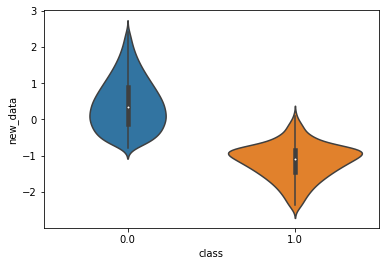

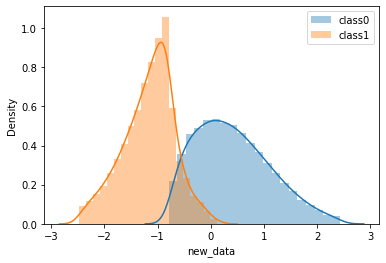


------------------------------------------

Pocet outlierov pri y=0 je: 160
Pocet outlierov pri y=1 je: 102
Bez transformacie - vyskusame len odstranit outliery
Pocet outlierov na odstranenie: 262
Korelacia medzi nasim atributom a y: -0.6597229460710929


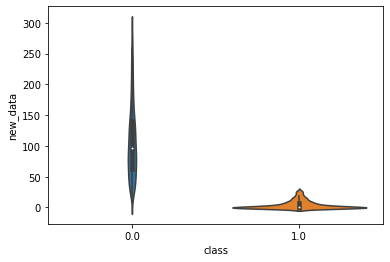

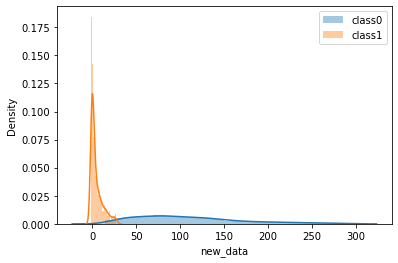


------------------------------------------



In [122]:
resolving_outliers_transformations_to_class(data, "skewness_oxygen")

Tu najvyhodnejsou kombinaciou je znova pouzitie PowerTransformer-a spolu s odstranenim outlierov

Korelacia medzi nasim atributom a y: -0.8074705821985075


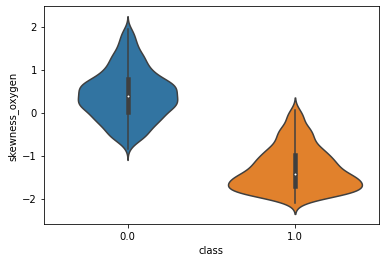

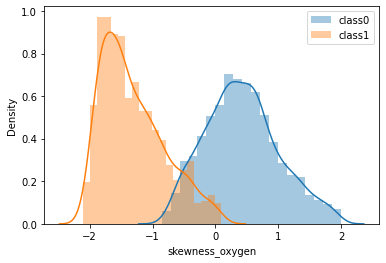

In [123]:
data = resolving_outliers_transformations_to_class(data, "skewness_oxygen", apply_combination=("PowerTransformer", True))
visual.univariate_num_to_class(data, "skewness_oxygen", show_regplot=False)

#### kurtosis_oxygen

Pocet outlierov: 0
Korelacia medzi nasim atributom a y: -0.7791333092692233


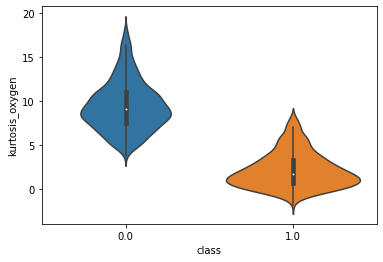

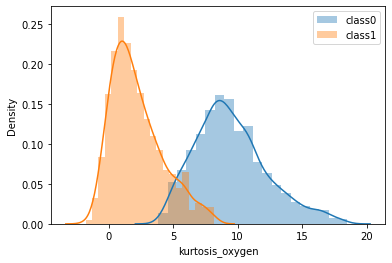

In [124]:
outliers = identify_outliers(data["kurtosis_oxygen"])
print("Pocet outlierov:", len(outliers))

visual.univariate_num_to_class(data, "kurtosis_oxygen", show_regplot=False)

PowerTransformer | metoda: yeo-johnson
Pocet outlierov pri y=0 je: 46
Pocet outlierov pri y=1 je: 11
Korelacia medzi nasim atributom a y: -0.7889306353348208


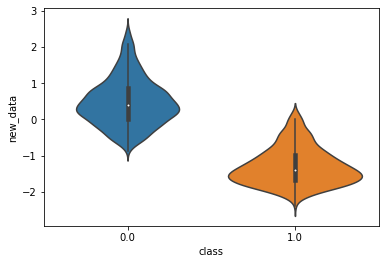

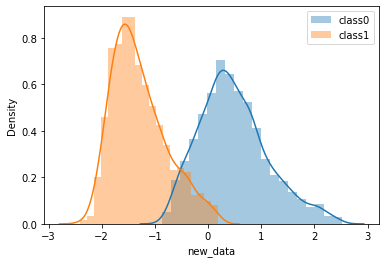



Vyskusame odstranit vsetky outliery z danej hornej distribucie
Pocet outlierov na odstranenie: 57
Korelacia medzi nasim atributom a y: -0.804835856634762


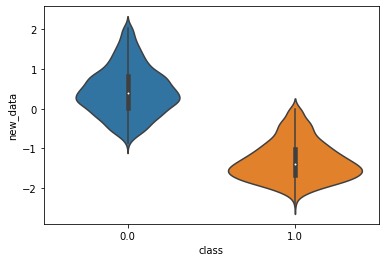

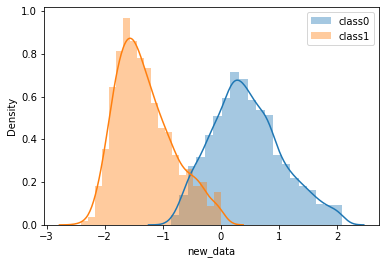


------------------------------------------

QuantileTransformer
Pocet outlierov pri y=0 je: 25
Pocet outlierov pri y=1 je: 23
Korelacia medzi nasim atributom a y: -0.7245445916426463


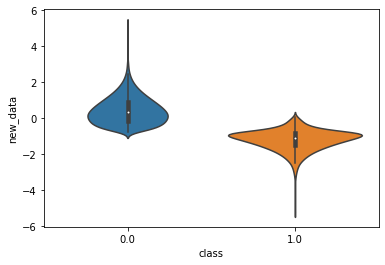

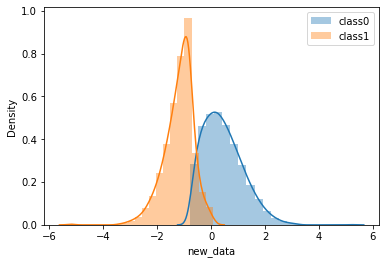



Vyskusame odstranit vsetky outliery z danej hornej distribucie
Pocet outlierov na odstranenie: 48
Korelacia medzi nasim atributom a y: -0.7318655746897763


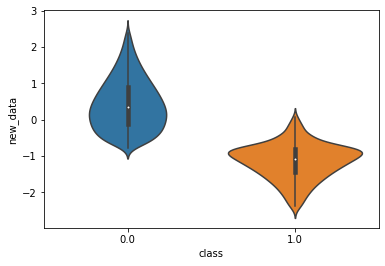

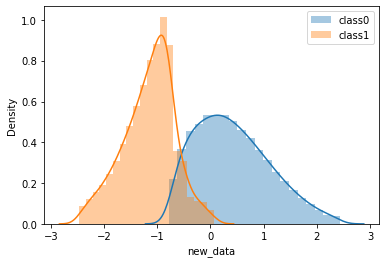


------------------------------------------

Pocet outlierov pri y=0 je: 51
Pocet outlierov pri y=1 je: 20
Bez transformacie - vyskusame len odstranit outliery
Pocet outlierov na odstranenie: 71
Korelacia medzi nasim atributom a y: -0.8002685586063312


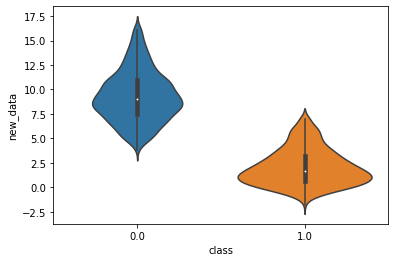

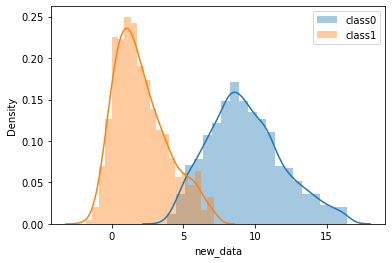


------------------------------------------



In [125]:
resolving_outliers_transformations_to_class(data, "kurtosis_oxygen")

Tu su 2 velmi podobne approache, ktore viacmenej dosahuju rovnake vysledky, a to PowerTransformer + odstranenie outlierov, a cisto odstranenie outlierov. No kombinacia s transformaciou zabezpecuje o trosku lepsiu korelaciu a menej potrebnych outlierov na odstranenie, a tak si vyberame prave ju.

Korelacia medzi nasim atributom a y: -0.804835856634762


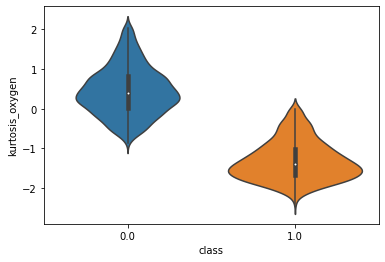

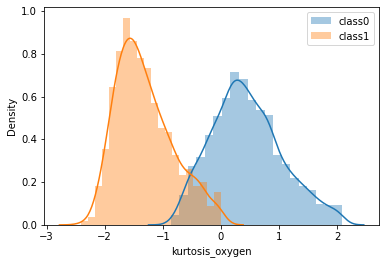

In [126]:
data = resolving_outliers_transformations_to_class(data, "kurtosis_oxygen", apply_combination=("PowerTransformer", True))
visual.univariate_num_to_class(data, "kurtosis_oxygen", show_regplot=False)

Teraz sa mozme sustredit na imputaciu missing values

In [127]:
data[oxygen_attributes].isnull().sum()

mean_oxygen        9
std_oxygen         9
skewness_oxygen    9
kurtosis_oxygen    9
dtype: int64

In [128]:
data[oxygen_attributes].isnull().all(axis=1).sum()

9

Sice vieme celkom dobre nahradit nejake chybajuce hodnoty atributov merani kyslika a glukozy na zaklade korelacie s inymi meraniami, vidime, ze prave 9 pacientov nema ziaden atribut o kysliku, inak povedane, maju atribut medical_info == NaN.

A toto by sme si uz moc trufali imputaciu atributov kyslika, pokial nemame ziadne hodnoty pre vsetky atributy kyslika. Tak ich iba jednoducho dropneme...

In [129]:
idx = data[data[oxygen_attributes].isnull().all(axis=1)].index.values
data = data.drop(index=idx)

Mozeme sa teraz pozriet na pairplot medzi atributmi kysliku, ako sme vlastne vycistili dataset a zmenili vztahy medzi nimi.

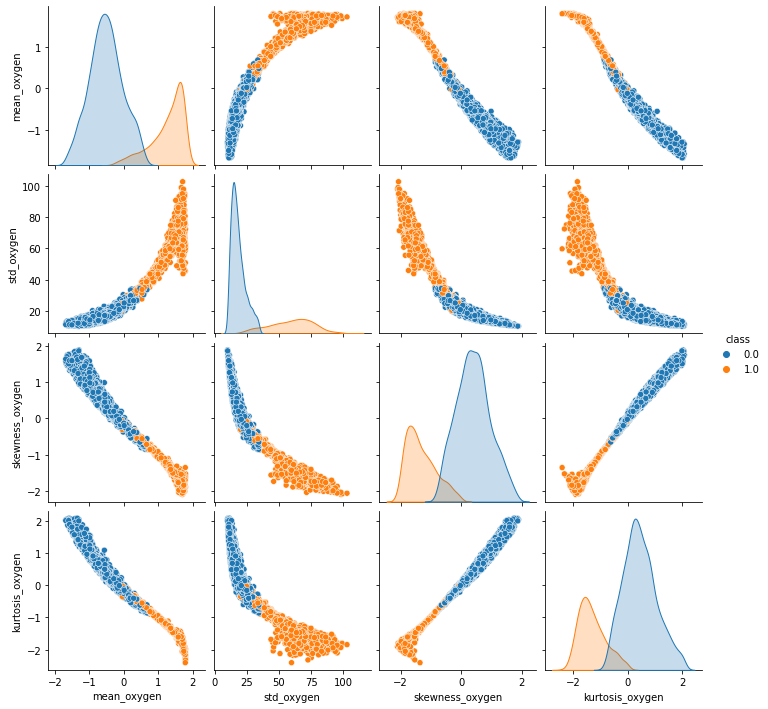

In [130]:
sns.pairplot(data[oxygen_attributes+["class"]], hue="class")

<AxesSubplot:>

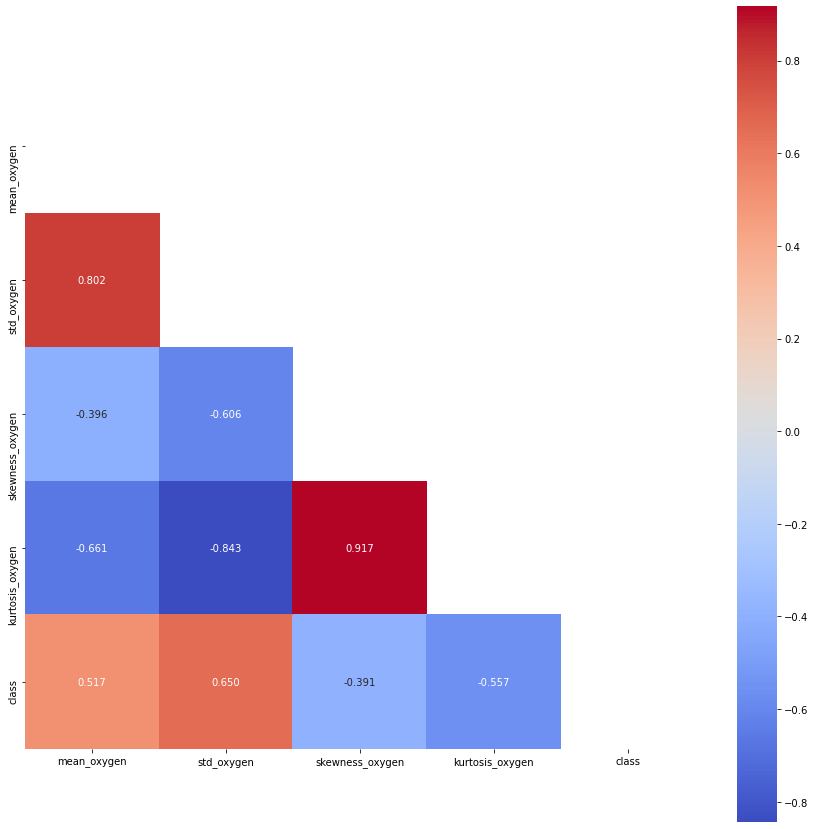

In [131]:
korelacie2 = data[oxygen_attributes+["class"]].corr()

maska = visual.heatmap_mask(korelacie2, threshold=0.5)

visual.f(figsize=(15,15))
sns.heatmap(data=korelacie, cmap="coolwarm", annot=True, fmt=".3f", square=True, mask=maska)

Este mozeme vypocitat, o kolko sme zlepsili dane korelacie

In [132]:
zmeny_korelacie = korelacie2.abs() - korelacie.abs()

<AxesSubplot:>

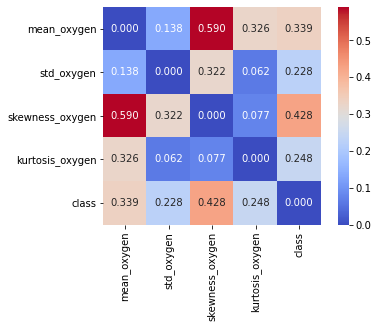

In [133]:
sns.heatmap(data=zmeny_korelacie, cmap="coolwarm", annot=True, fmt=".3f", square=True)

Ako mozno vidiet, ziadne korelacie som nezhorsil, len zlepsil medzi atributmi kyslika, resp. target atributu

# Atributy glukozy

In [136]:
glucose_attributes = ["skewness_glucose", "kurtosis_glucose", "mean_glucose", "std_glucose"]

In [137]:
data['mean_glucose'] = pd.to_numeric(data['mean_glucose'], errors= 'coerce')

Pretipujeme si mean_glucose aby sme s nim vedeli pracovat. Povodne bol vedeny ako string, zmenili sme ho na float

Pred upravou sa pozrieme na vztahy a korelacie

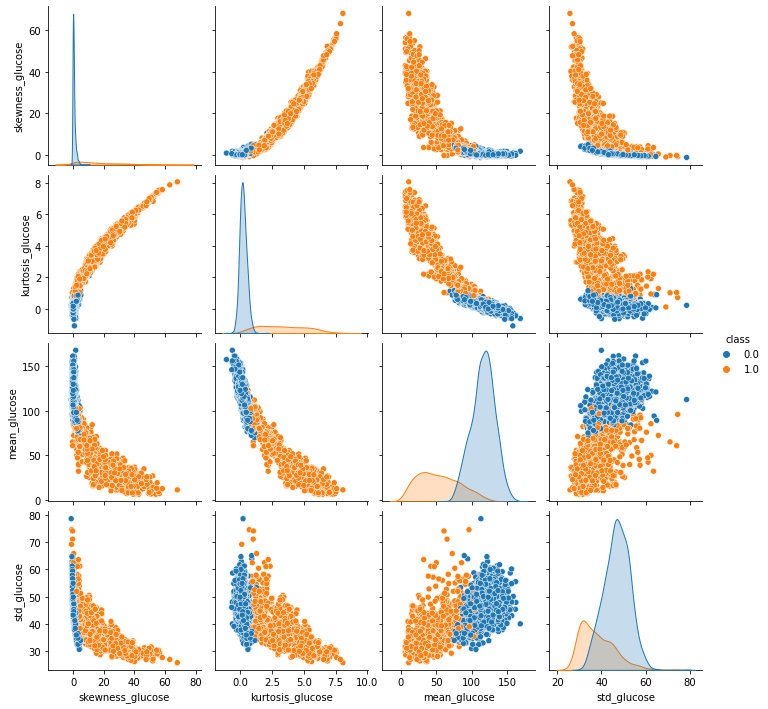

In [138]:
sns.pairplot(data[glucose_attributes+["class"]], hue="class")

<AxesSubplot:>

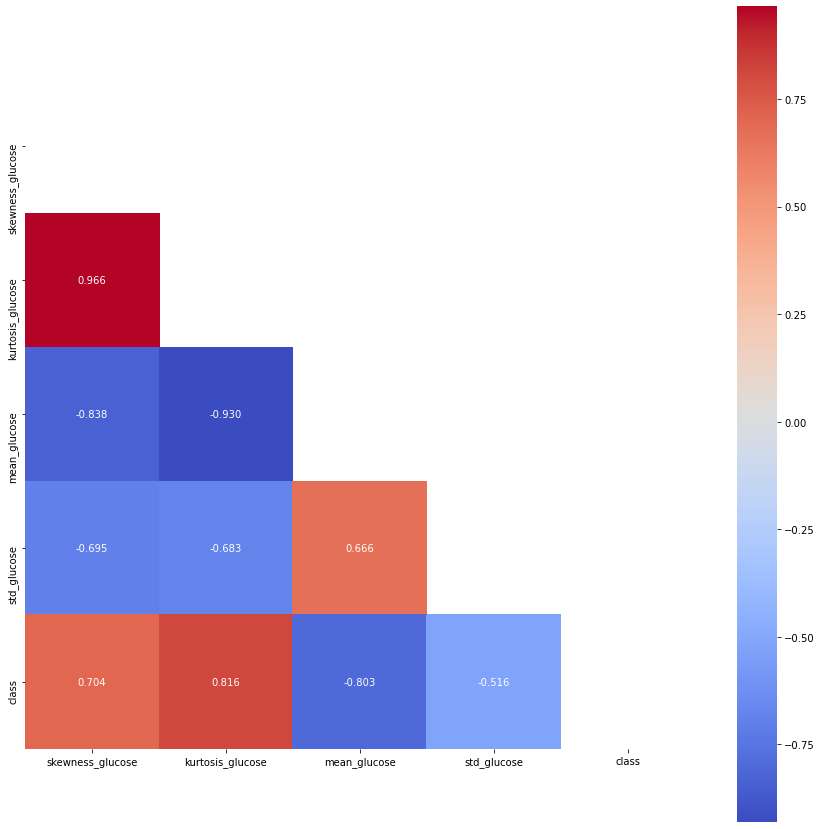

In [139]:
korelacie = data[glucose_attributes+["class"]].corr()

maska = visual.heatmap_mask(korelacie, threshold=0.5)

visual.f(figsize=(15,15))
sns.heatmap(data=korelacie, cmap="coolwarm", annot=True, fmt=".3f", square=True, mask=maska)

#### skewness_glucose

Pocet outlierov: 629
Korelacia medzi nasim atributom a y: 0.7038573827329189


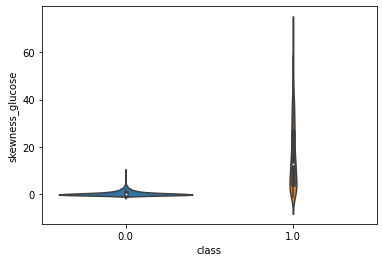

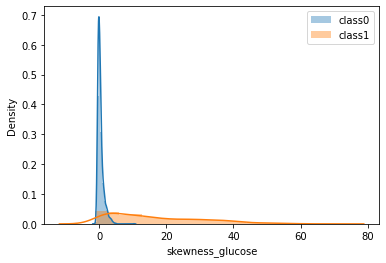

In [140]:
outliers = identify_outliers(data["skewness_glucose"])
print("Pocet outlierov:", len(outliers))

visual.univariate_num_to_class(data, "skewness_glucose", show_regplot=False)

Rozdelenim hodnout do dvoch distribucii sme znizili pocet outlierov z 629 na 59 

PowerTransformer | metoda: yeo-johnson
Pocet outlierov pri y=0 je: 12
Pocet outlierov pri y=1 je: 47
Korelacia medzi nasim atributom a y: 0.753776310498792


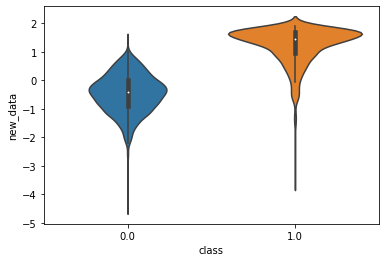

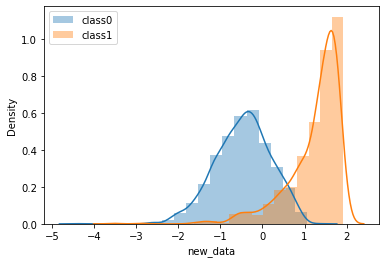



Vyskusame odstranit vsetky outliery z danej hornej distribucie
Pocet outlierov na odstranenie: 59
Korelacia medzi nasim atributom a y: 0.7950881236115538


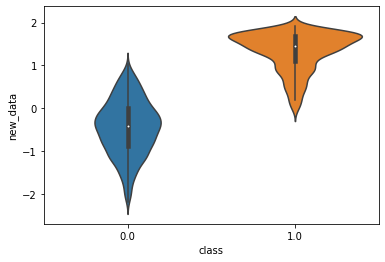

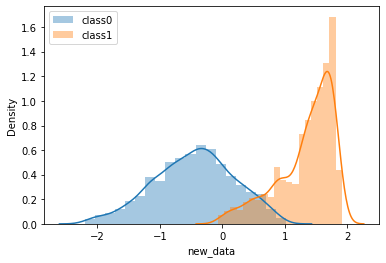


------------------------------------------

QuantileTransformer
Pocet outlierov pri y=0 je: 21
Pocet outlierov pri y=1 je: 55
Korelacia medzi nasim atributom a y: 0.6872301667230334


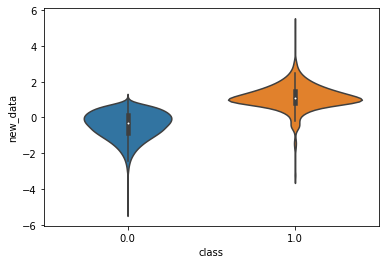

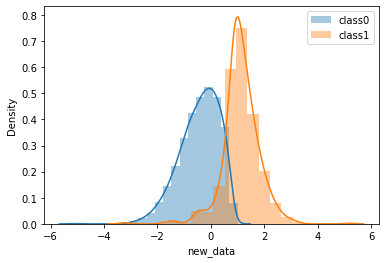



Vyskusame odstranit vsetky outliery z danej hornej distribucie
Pocet outlierov na odstranenie: 76
Korelacia medzi nasim atributom a y: 0.7201711400960171


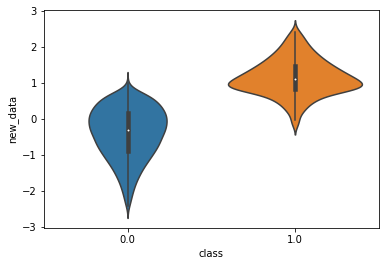

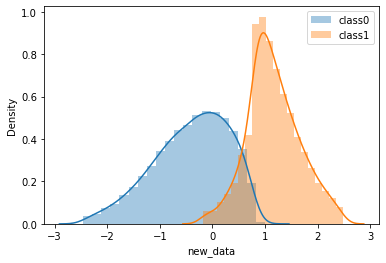


------------------------------------------

Pocet outlierov pri y=0 je: 170
Pocet outlierov pri y=1 je: 2
Bez transformacie - vyskusame len odstranit outliery
Pocet outlierov na odstranenie: 172
Korelacia medzi nasim atributom a y: 0.707614988312163


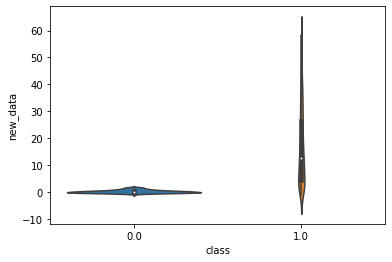

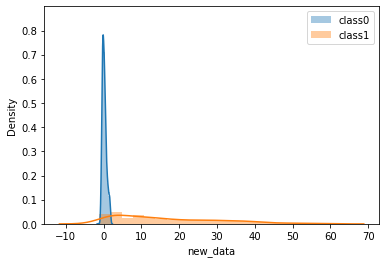


------------------------------------------



In [142]:
resolving_outliers_transformations_to_class(data, "skewness_glucose")

Prisli sme na to ze pouzitim PowerTransform a nasledne odstaranenie outliarov je najefektivnejsi sposob pre zisk najvyssej korelacie medzi skewness glucose a class

Korelacia medzi nasim atributom a y: 0.7950881236115538


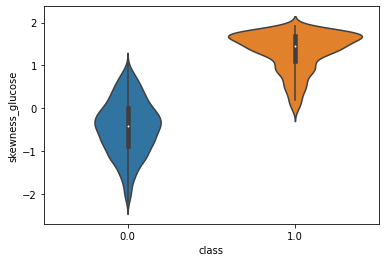

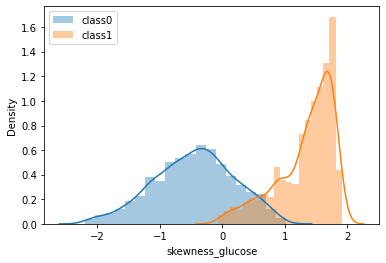

In [143]:
data = resolving_outliers_transformations_to_class(data, "skewness_glucose", apply_combination=("PowerTransformer", True))
visual.univariate_num_to_class(data, "skewness_glucose", show_regplot=False)

#### kurtosis_glucose

Pocet outlierov: 577
Korelacia medzi nasim atributom a y: 0.8391645746405144


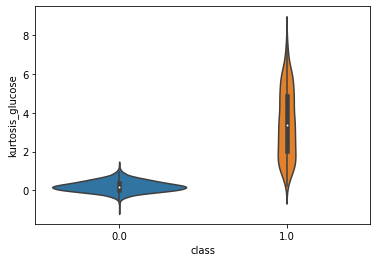

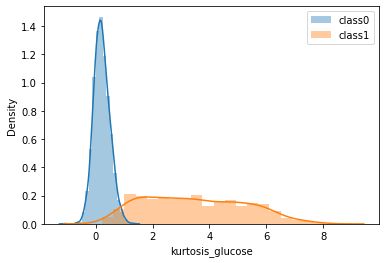

In [144]:
outliers = identify_outliers(data["kurtosis_glucose"])
print("Pocet outlierov:", len(outliers))

visual.univariate_num_to_class(data, "kurtosis_glucose", show_regplot=False)

PowerTransformer | metoda: yeo-johnson
Pocet outlierov pri y=0 je: 64
Pocet outlierov pri y=1 je: 18
Korelacia medzi nasim atributom a y: 0.816933196249525


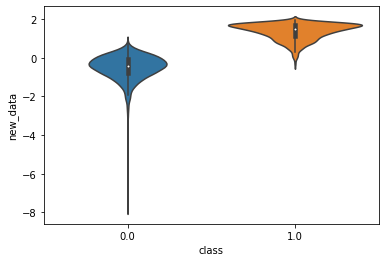

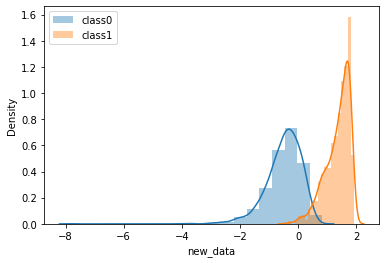



Vyskusame odstranit vsetky outliery z danej hornej distribucie
Pocet outlierov na odstranenie: 82
Korelacia medzi nasim atributom a y: 0.8567891983971527


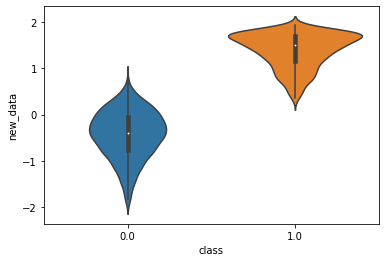

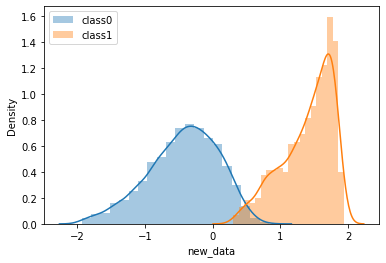


------------------------------------------

QuantileTransformer
Pocet outlierov pri y=0 je: 24
Pocet outlierov pri y=1 je: 23
Korelacia medzi nasim atributom a y: 0.7331883884485707


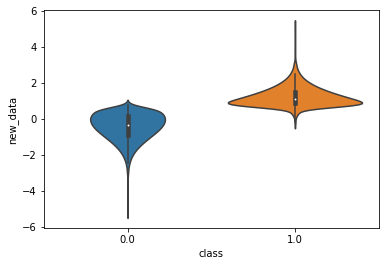

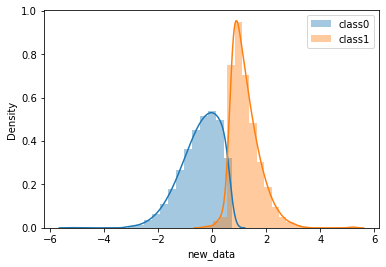



Vyskusame odstranit vsetky outliery z danej hornej distribucie
Pocet outlierov na odstranenie: 47
Korelacia medzi nasim atributom a y: 0.741466185784164


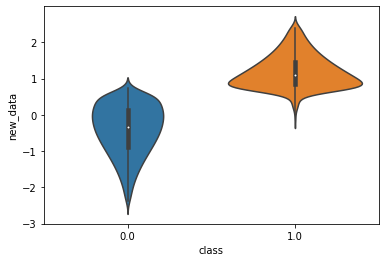

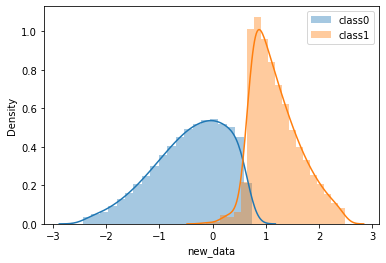


------------------------------------------

Pocet outlierov pri y=0 je: 25
Pocet outlierov pri y=1 je: 0
Bez transformacie - vyskusame len odstranit outliery
Pocet outlierov na odstranenie: 25
Korelacia medzi nasim atributom a y: 0.8400573415971034


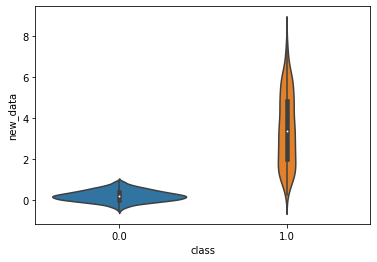

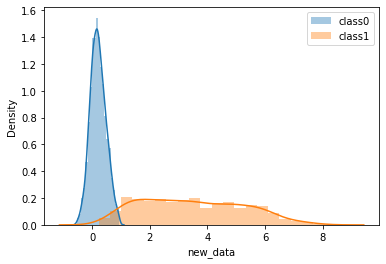


------------------------------------------



In [142]:
resolving_outliers_transformations_to_class(data, "kurtosis_glucose")

Vidime ze ziadna z tychto transformacii nezlepsuje korelaciu a tak vykoname len odstranenie outlierov

Korelacia medzi nasim atributom a y: 0.8400573415971034


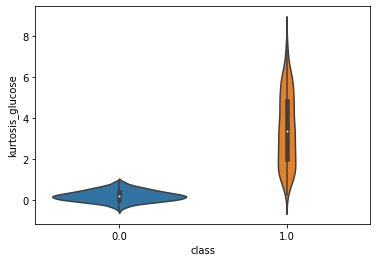

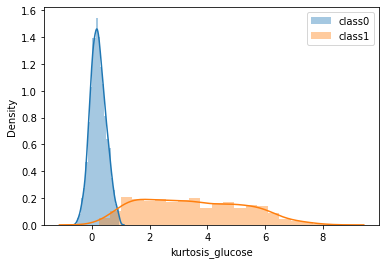

In [145]:
data = resolving_outliers_transformations_to_class(data, "kurtosis_glucose", apply_combination=(None, True))
visual.univariate_num_to_class(data, "kurtosis_glucose", show_regplot=False)

#### mean_glucose

Atribut mean_glucose sme museli pretipovat lebo bol vedeny ako object

Pocet outlierov: 154
Korelacia medzi nasim atributom a y: -0.8291291755826192


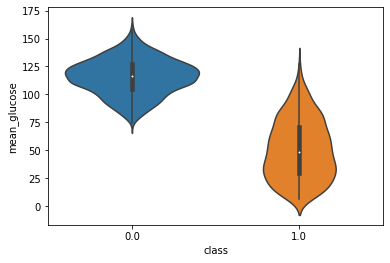

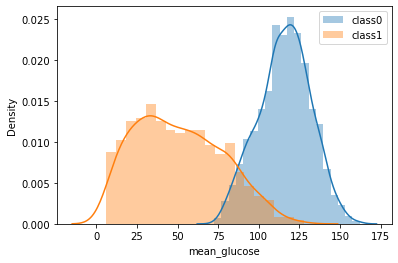

In [146]:
outliers = identify_outliers(data["mean_glucose"])
print("Pocet outlierov:", len(outliers))

visual.univariate_num_to_class(data, "mean_glucose", show_regplot=False)

Pocet outlierov sa zmensil rozdelenim distribucie z 154 na 19.

PowerTransformer | metoda: yeo-johnson
Pocet outlierov pri y=0 je: 9
Pocet outlierov pri y=1 je: 10
Korelacia medzi nasim atributom a y: -0.8055306249883938


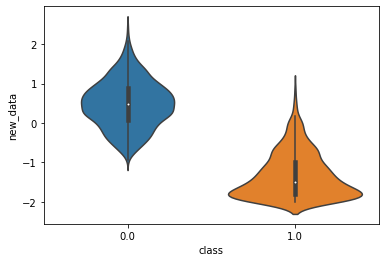

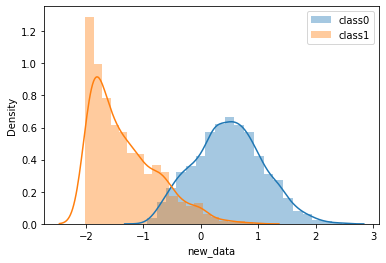



Vyskusame odstranit vsetky outliery z danej hornej distribucie
Pocet outlierov na odstranenie: 19
Korelacia medzi nasim atributom a y: -0.8151991982123253


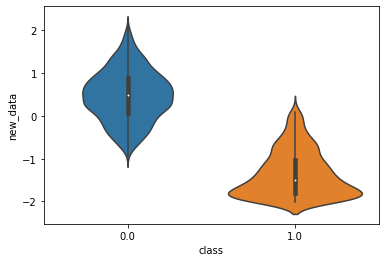

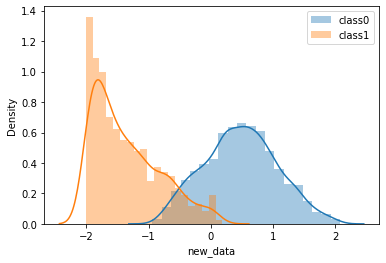


------------------------------------------

QuantileTransformer
Pocet outlierov pri y=0 je: 20
Pocet outlierov pri y=1 je: 27
Korelacia medzi nasim atributom a y: -0.7140220036624599


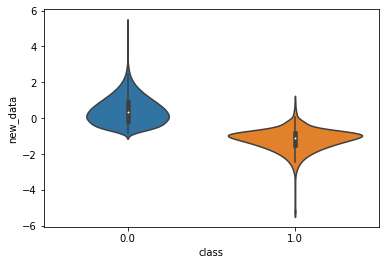

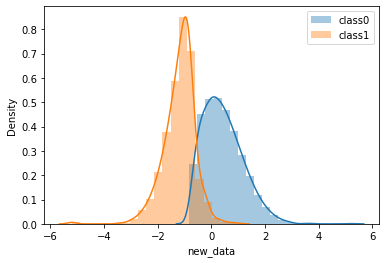



Vyskusame odstranit vsetky outliery z danej hornej distribucie
Pocet outlierov na odstranenie: 47
Korelacia medzi nasim atributom a y: -0.7272569834259747


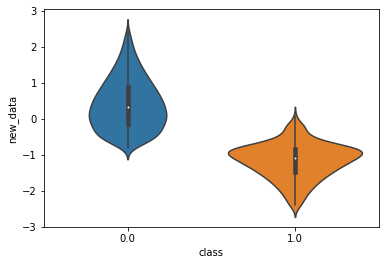

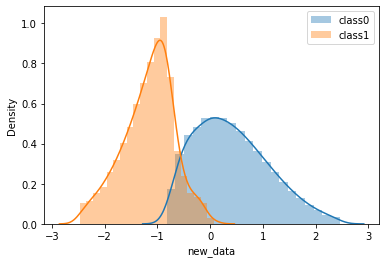


------------------------------------------

Pocet outlierov pri y=0 je: 4
Pocet outlierov pri y=1 je: 0
Bez transformacie - vyskusame len odstranit outliery
Pocet outlierov na odstranenie: 4
Korelacia medzi nasim atributom a y: -0.829848311689708


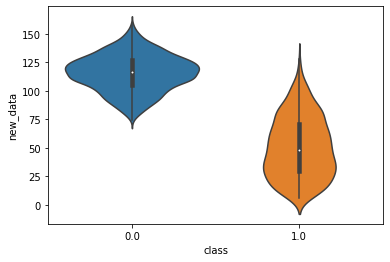

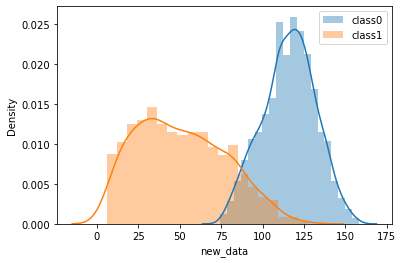


------------------------------------------



In [147]:
resolving_outliers_transformations_to_class(data, "mean_glucose")

Korelacia medzi nasim atributom a y: -0.829848311689708


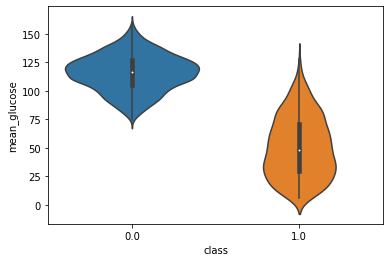

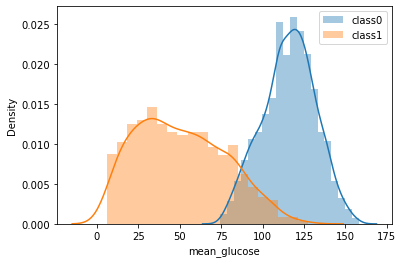

In [148]:
data = resolving_outliers_transformations_to_class(data, "mean_glucose", apply_combination=(None, True))
visual.univariate_num_to_class(data, "mean_glucose", show_regplot=False)

#### std_glucose

Pocet outlierov: 0
Korelacia medzi nasim atributom a y: -0.5727852444933429


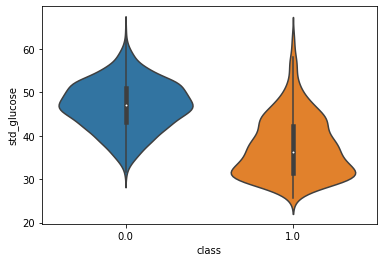

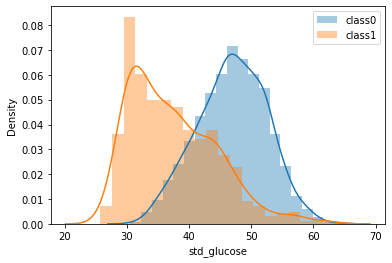

In [149]:
outliers = identify_outliers(data["std_glucose"])
print("Pocet outlierov:", len(outliers))

visual.univariate_num_to_class(data, "std_glucose", show_regplot=False)

PowerTransformer | metoda: yeo-johnson
Pocet outlierov pri y=0 je: 5
Pocet outlierov pri y=1 je: 15
Korelacia medzi nasim atributom a y: -0.5543872535056044


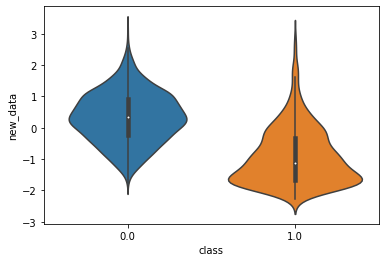

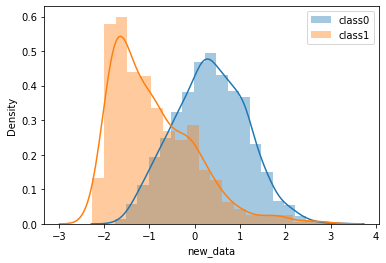



Vyskusame odstranit vsetky outliery z danej hornej distribucie
Pocet outlierov na odstranenie: 20
Korelacia medzi nasim atributom a y: -0.5850552319624647


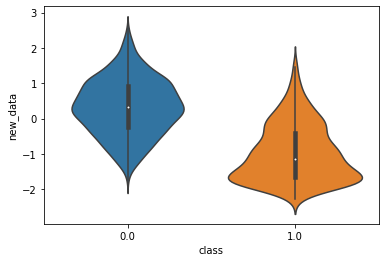

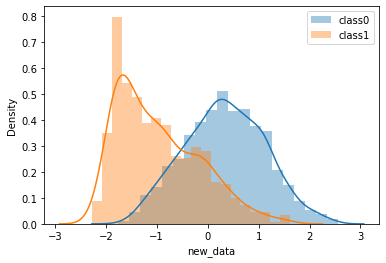


------------------------------------------

QuantileTransformer
Pocet outlierov pri y=0 je: 12
Pocet outlierov pri y=1 je: 23
Korelacia medzi nasim atributom a y: -0.5394030903271563


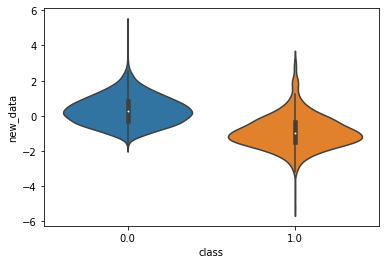

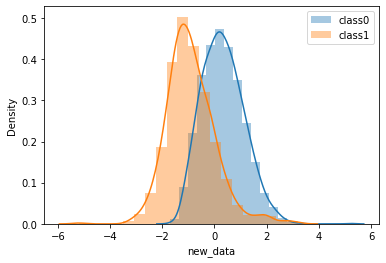



Vyskusame odstranit vsetky outliery z danej hornej distribucie
Pocet outlierov na odstranenie: 35
Korelacia medzi nasim atributom a y: -0.5831915717225519


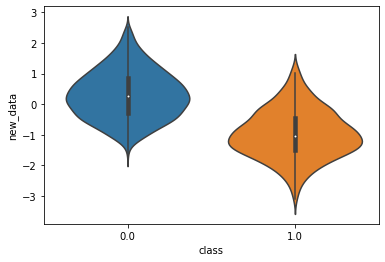

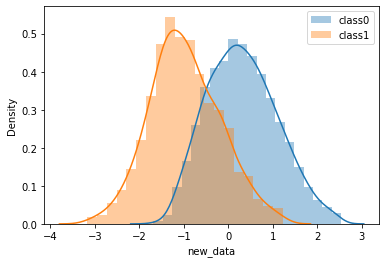


------------------------------------------

Pocet outlierov pri y=0 je: 4
Pocet outlierov pri y=1 je: 5
Bez transformacie - vyskusame len odstranit outliery
Pocet outlierov na odstranenie: 9
Korelacia medzi nasim atributom a y: -0.5856008459889308


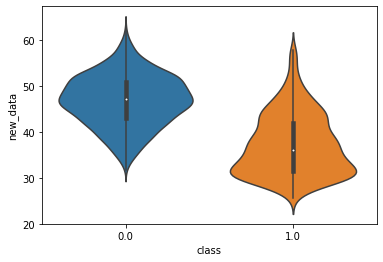

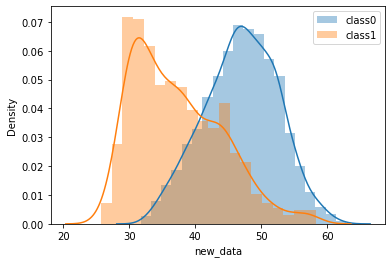


------------------------------------------



In [150]:
resolving_outliers_transformations_to_class(data, "std_glucose")

Korelacia medzi nasim atributom a y: -0.5856008459889308


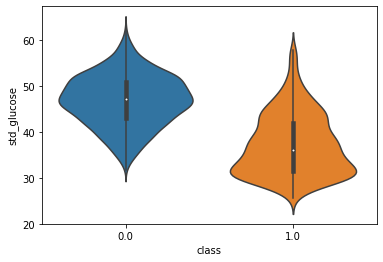

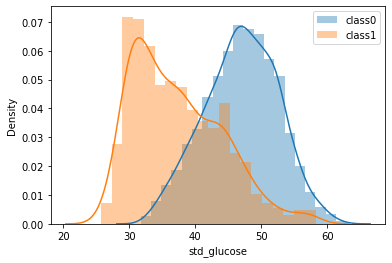

In [151]:
data = resolving_outliers_transformations_to_class(data, "std_glucose", apply_combination=(None, True))
visual.univariate_num_to_class(data, "std_glucose", show_regplot=False)

Teraz sa mozeme venovat missing values

In [152]:
data[glucose_attributes].isnull().sum()

skewness_glucose      5
kurtosis_glucose      2
mean_glucose        331
std_glucose         340
dtype: int64

Vidime ze ich he celkom dost

In [151]:
data[glucose_attributes].isnull().all(axis=1).sum()

0

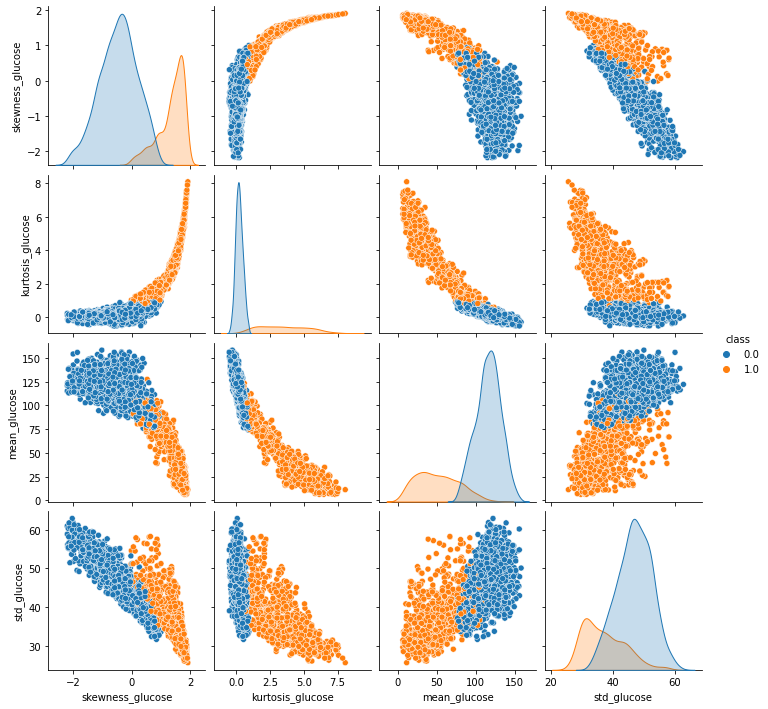

In [153]:
sns.pairplot(data[glucose_attributes+["class"]], hue="class")

<AxesSubplot:>

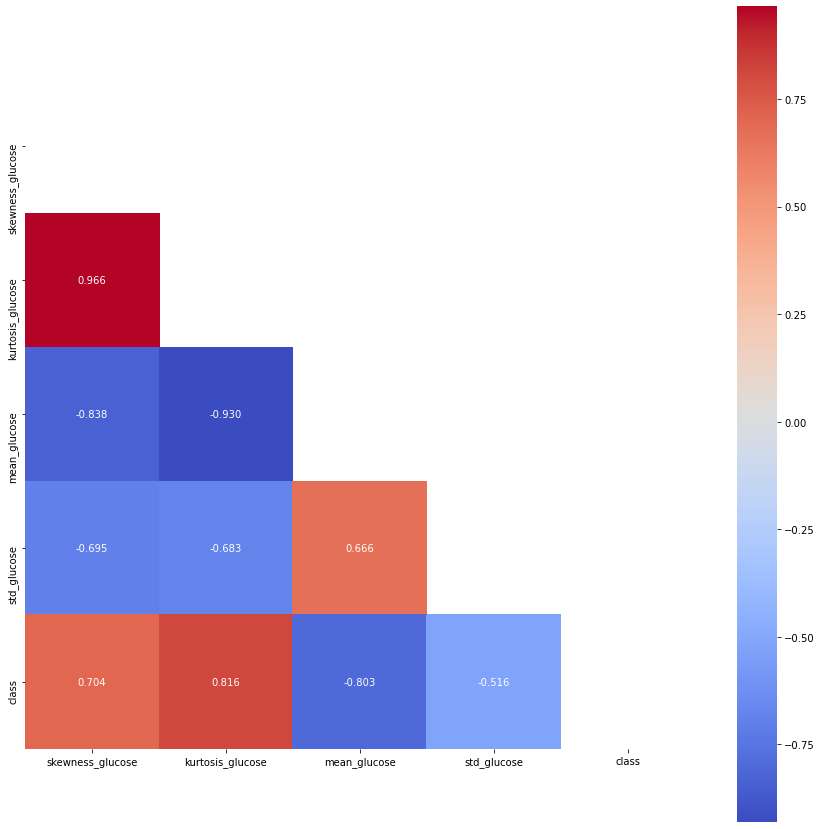

In [154]:
korelacie2 = data[glucose_attributes+["class"]].corr()

maska = visual.heatmap_mask(korelacie2, threshold=0.5)

visual.f(figsize=(15,15))
sns.heatmap(data=korelacie, cmap="coolwarm", annot=True, fmt=".3f", square=True, mask=maska)

In [155]:
zmeny_korelacie = korelacie2.abs() - korelacie.abs()

<AxesSubplot:>

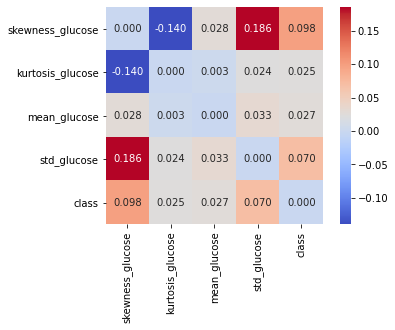

In [156]:
sns.heatmap(data=zmeny_korelacie, cmap="coolwarm", annot=True, fmt=".3f", square=True)

## Imputacia hodnot glukozy a kysliku 

In [157]:
imp = impute.IterativeImputer(max_iter=20)

data[glucose_attributes + oxygen_attributes] = imp.fit_transform(data[glucose_attributes + oxygen_attributes])


In [158]:
data[glucose_attributes].isnull().sum()

skewness_glucose    0
kurtosis_glucose    0
mean_glucose        0
std_glucose         0
dtype: int64

Este sa pozrieme ako sa nam zmenil pairplot ked sme doplnili chybajuce data IterativeImputerom

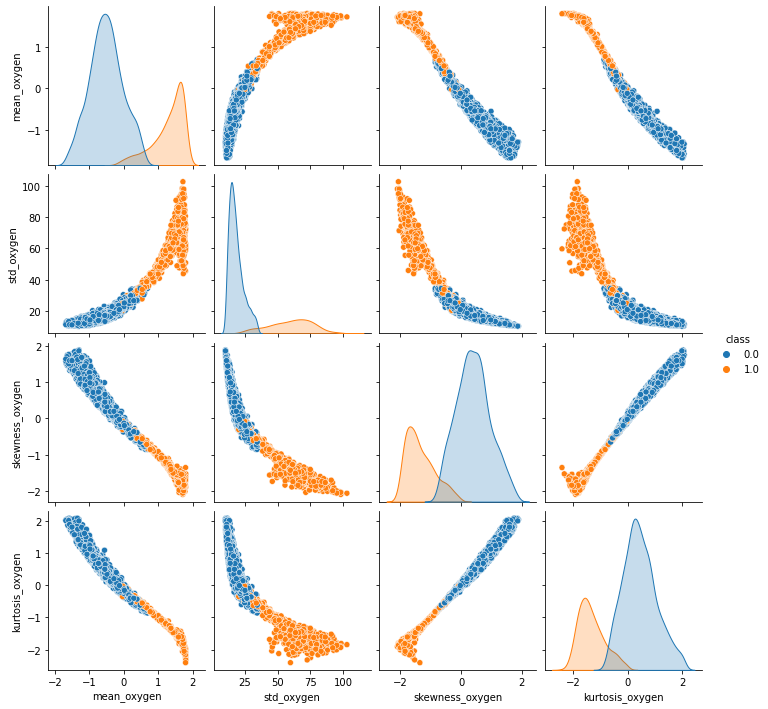

In [161]:
sns.pairplot(data[oxygen_attributes+["class"]], hue="class")

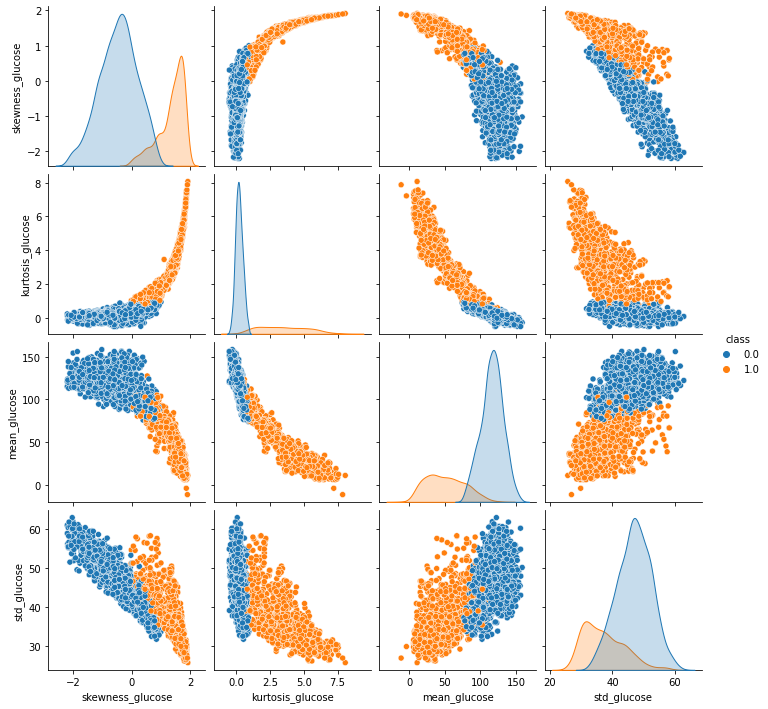

In [160]:
sns.pairplot(data[glucose_attributes+["class"]], hue="class")

Toto je basic layout, ako budeme postupne tvorit velky PIPELINE, do ktoreho vsetok preprocessing hodime. Avsak mozme tam hodit iba veci, pri ktorych nepracujeme s target triedou y, teda v PIPELINE neodstranujeme samples.

In [158]:
class TransformaciaMS_Relationship(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self):
        self.ordinal_encoder = None
        self.iterative_imputer = None
        
    def fit(self, X, y=None):
        
        print("FIT")
        
        columns = X.columns.values
        indices = X.index

        null_values = pd.DataFrame(index=pd.Index([-1]), columns=columns, data=[[np.nan for i in range(len(columns))]])
        X = pd.concat([null_values,X])

        self.ordinal_encoder = ce.ordinal.OrdinalEncoder(handle_missing="return_nan", handle_unknown="return_nan")
        X = self.ordinal_encoder.fit_transform(X)
        
        X = X[1:]

        self.iterative_imputer = impute.IterativeImputer(max_iter=20, random_state=42, initial_strategy="most_frequent", 
                                              min_value=X.min(), max_value=X.max())

        
        try:
            X = self.iterative_imputer.fit(X)
        except (ValueError, np.linalg.LinAlgError):
            print("Jeden error bol trapnuty, kedy funkcii vadili NaNs. Tento error je ale divny, lebo mu to vadi", \
              "len prvy krat, a potom to uz ide...")
            X = self.iterative_imputer.fit(X)
            
        return self
               

    def transform(self, X):
        print("TRANSFORM")
        columns = X.columns.values
    
        X = self.ordinal_encoder.transform(X)
        X = self.iterative_imputer.transform(X).round()
        
        X = pd.DataFrame(data=X, columns=columns, index=indices)
        
        X = self.ordinal_encoder.inverse_transform(X)
        
        return X
    

In [159]:
pip = pipeline.Pipeline(steps=[
    ("moja_transf", TransformaciaMS_Relationship()),
    ("one_hot_enc", preprocessing.OneHotEncoder())
])


col_transform = compose.ColumnTransformer(transformers=[
        ('vztahy', pip, ["marital-status", "relationship"])
    ])

PIPE = pipeline.Pipeline(steps=[
    ("transform", col_transform),
    ("model", svm.SVR())
])

NameError: name 'svm' is not defined

# Znovupoužiteľnosť predspracovania